# Machine Learning Methods Testing for MEV Detection

## ⚠️ IMPORTANT: Why This Approach Failed

**This multi-class classification approach produced trivial, meaningless results** despite showing "perfect" accuracy. See `WHY_ML_FAILED.md` for detailed analysis.

### Key Issues:
1. **Extreme class imbalance** (MEV: 7.6%, Aggregator: 88.6%) → Model predicts only majority class
2. **Zero feature importance** → Model uses no features, just memorizes majority class
3. **Insufficient samples** → Cannot learn complex MEV patterns
4. **Signer-level aggregation** → Loses critical transaction-level attack patterns

### Results Observed:
- Accuracy: 1.0 (perfect but meaningless - model always predicts majority class)
- MEV Recall: 0.0 (model never detects MEV)
- Feature Importance: All zeros (model doesn't use features)
- Test Set: Only 2 samples, single class

### Recommendation:
**Use binary classification instead** (`07a_ml_classification_binary.ipynb`) which:
- Focuses on MEV detection (the actual goal)
- Handles imbalance with SMOTE + class weights
- Achieves better MEV recall
- Is simpler and more effective

---

## Original Overview (For Reference)

This notebook tests various ML methods on MEV attacker data to distinguish:
- **MEV bots** (actual attackers)
- **Aggregators** (Jupiter, etc. - legitimate routing)
- **Wash Trading** (volume inflation)
- **Regular Trading** (legitimate market making/arbitrage)

##  Dataset

**Source**: `pamm_clean_final.parquet` (5.5M+ transaction records)

**Feature Engineering**: 
- Features are created at the **signer level** (wallet address) from transaction patterns
- Automatically generates classifications based on behavioral patterns
- Much larger and more diverse than previous aggregated dataset

**Features**: 
- `total_trades`, `trades_per_hour`, `aggregator_likelihood`
- `late_slot_ratio`, `oracle_backrun_ratio`, `high_bytes_ratio`
- `cluster_ratio`, `mev_score`, `wash_trading_score`

**Target Labels** (auto-generated):
- LIKELY MEV BOT, LIKELY AGGREGATOR, LIKELY WASH TRADING, POSSIBLE MEV, REGULAR TRADE BOT

##  Methods Tested

1. **Gaussian Mixture Model (GMM)** - Unsupervised density estimation & clustering
2. **Isolation Forest** - Unsupervised anomaly detection
3. **Random Forest** - Supervised classification with feature importance
4. **XGBoost** - Advanced gradient boosting classification
5. **Support Vector Machine (SVM)** - Decision boundary optimization
6. **Logistic Regression** - Interpretable linear baseline

##  Key Improvements

- **Adaptive Hyperparameters**: Models automatically adjust based on dataset size
- **Comprehensive Visualizations**: MLVisualizer class for standardized plots
- **Robust Error Handling**: Gracefully handles edge cases (single class, small datasets)
- **Performance Optimizations**: Parallel processing, vectorized operations
- **Detailed Documentation**: Markdown notes before each section explain methodology

## ️ Important Limitations

**Data Collection Constraints**:
- **No Jito API Access**: Cannot access mempool/bundle data (analysis limited to on-chain transactions)
- **No Transaction Amounts**: Cannot verify profitability (pattern-based detection only)
- **No Failed Transactions**: Only successful events in dataset
- **No Program IDs**: Cannot definitively identify Jupiter vs MEV programs
- **Limited Time Window**: ~11 hours of data (no long-term patterns)
- **Same-Slot Only**: Cannot detect cross-slot MEV attacks

**Impact**: Analysis is pattern-based rather than profit-based. Results should be interpreted as "suspicious patterns" rather than confirmed MEV attacks. See `ML_MEV_DETECTION_METHODS.md` for complete limitations documentation.

##  Results Location

**All outputs saved to**: `scripts/derived/ml_results/`

After running the notebook, check this directory for:
- 6 visualization PNG files
- 1 JSON results summary file

In [12]:
"""
Machine Learning Methods Testing for MEV Detection
Tests various ML methods on MEV attacker data to distinguish:
- MEV bots vs Aggregators vs Wash Trading vs Regular Trading

Methods tested:
1. Gaussian Mixture Model (GMM) - Density estimation
2. Isolation Forest - Anomaly detection
3. Random Forest - Classification
4. XGBoost - Classification
5. Support Vector Machine (SVM) - Classification
6. Logistic Regression - Classification baseline
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve
)
import xgboost as xgb
import os
import warnings
from collections import Counter
warnings.filterwarnings('ignore')

# Import imbalanced-learn for handling class imbalance
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTEENN
    from imblearn.ensemble import BalancedRandomForestClassifier
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("Warning: imbalanced-learn not installed. SMOTE and other resampling methods will be skipped.")
    print("Install with: pip install imbalanced-learn")
    IMBLEARN_AVAILABLE = False

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Create output directory if it doesn't exist
os.makedirs('derived/ml_results', exist_ok=True)

# ============================================================================
# VISUALIZATION MODULE
# ============================================================================
class MLVisualizer:
    """Comprehensive visualization module for ML model results"""
    
    def __init__(self, output_dir='derived/ml_results'):
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        self.colors = sns.color_palette("husl", 10)
        
    def plot_model_comparison(self, models_data, save_path=None):
        """Plot comparison of multiple models"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Accuracy comparison
        ax1 = axes[0, 0]
        model_names = [d['name'] for d in models_data]
        train_accs = [d['train_acc'] for d in models_data]
        test_accs = [d['test_acc'] for d in models_data]
        x = np.arange(len(model_names))
        width = 0.35
        ax1.bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color=self.colors[0])
        ax1.bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color=self.colors[1])
        ax1.set_xlabel('Model', fontsize=12)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1.1])
        
        # 2. Feature importance comparison (if available)
        ax2 = axes[0, 1]
        if 'feature_importance' in models_data[0]:
            # Get top features from first model
            top_features = models_data[0]['feature_importance'].head(5)
            feature_names = top_features['feature'].values
            n_features = len(feature_names)
            x_pos = np.arange(n_features)
            
            for idx, model_data in enumerate(models_data[:3]):  # Top 3 models
                if 'feature_importance' in model_data:
                    importances = []
                    for feat in feature_names:
                        feat_row = model_data['feature_importance'][
                            model_data['feature_importance']['feature'] == feat
                        ]
                        if len(feat_row) > 0:
                            importances.append(feat_row['importance'].values[0])
                        else:
                            importances.append(0)
                    ax2.plot(x_pos, importances, 'o-', label=model_data['name'], 
                            linewidth=2, markersize=6, color=self.colors[idx])
            
            ax2.set_xlabel('Feature', fontsize=12)
            ax2.set_ylabel('Importance', fontsize=12)
            ax2.set_title('Top 5 Feature Importance Comparison', fontsize=14, fontweight='bold')
            ax2.set_xticks(x_pos)
            ax2.set_xticklabels(feature_names, rotation=45, ha='right')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Feature importance\nnot available', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Feature Importance Comparison', fontsize=14, fontweight='bold')
        
        # 3. Training vs Test Performance
        ax3 = axes[1, 0]
        ax3.scatter(train_accs, test_accs, s=200, alpha=0.6, c=self.colors[:len(model_names)])
        for i, name in enumerate(model_names):
            ax3.annotate(name, (train_accs[i], test_accs[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
        ax3.plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Perfect Fit')
        ax3.set_xlabel('Train Accuracy', fontsize=12)
        ax3.set_ylabel('Test Accuracy', fontsize=12)
        ax3.set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim([0, 1.1])
        ax3.set_ylim([0, 1.1])
        
        # 4. Performance Metrics Summary
        ax4 = axes[1, 1]
        metrics_summary = []
        for model_data in models_data:
            metrics_summary.append({
                'Model': model_data['name'],
                'Train Acc': model_data['train_acc'],
                'Test Acc': model_data['test_acc']
            })
        metrics_df = pd.DataFrame(metrics_summary)
        metrics_df.set_index('Model', inplace=True)
        metrics_df.plot(kind='bar', ax=ax4, color=[self.colors[0], self.colors[1]], alpha=0.8)
        ax4.set_ylabel('Accuracy', fontsize=12)
        ax4.set_title('Performance Summary', fontsize=14, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3, axis='y')
        ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_confusion_matrices(self, models_preds, y_true, class_names, save_path=None):
        """Plot confusion matrices for multiple models"""
        n_models = len(models_preds)
        cols = 2
        rows = (n_models + 1) // 2
        fig, axes = plt.subplots(rows, cols, figsize=(16, 8*rows))
        if n_models == 1:
            axes = [axes]
        else:
            axes = axes.flatten()
        
        for idx, (name, pred) in enumerate(models_preds.items()):
            ax = axes[idx]
            cm = confusion_matrix(y_true, pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                       xticklabels=class_names, yticklabels=class_names,
                       cbar_kws={'label': 'Count'})
            ax.set_title(f'Confusion Matrix: {name}', fontsize=12, fontweight='bold')
            ax.set_ylabel('True Label', fontsize=11)
            ax.set_xlabel('Predicted Label', fontsize=11)
        
        # Hide unused subplots
        for idx in range(n_models, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_gmm_analysis(self, gmm_results, save_path=None):
        """Plot GMM analysis results"""
        if len(gmm_results) == 0:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, 'GMM not fitted\n(insufficient samples)', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title('GMM Analysis', fontsize=14, fontweight='bold')
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            return fig
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # BIC/AIC plot
        ax1 = axes[0]
        n_comp = [r['n_components'] for r in gmm_results]
        bic_vals = [r['bic'] for r in gmm_results]
        aic_vals = [r['aic'] for r in gmm_results]
        ax1.plot(n_comp, bic_vals, 'o-', label='BIC', linewidth=2, markersize=10, color=self.colors[0])
        ax1.plot(n_comp, aic_vals, 's-', label='AIC', linewidth=2, markersize=10, color=self.colors[1])
        ax1.set_xlabel('Number of Components', fontsize=12)
        ax1.set_ylabel('Score', fontsize=12)
        ax1.set_title('GMM Model Selection (BIC/AIC)', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Purity plot
        ax2 = axes[1]
        train_purity = [r['train_purity'] for r in gmm_results]
        test_purity = [r['test_purity'] for r in gmm_results]
        ax2.plot(n_comp, train_purity, 'o-', label='Train Purity', linewidth=2, markersize=10, color=self.colors[2])
        ax2.plot(n_comp, test_purity, 's-', label='Test Purity', linewidth=2, markersize=10, color=self.colors[3])
        ax2.set_xlabel('Number of Components', fontsize=12)
        ax2.set_ylabel('Purity', fontsize=12)
        ax2.set_title('Cluster Purity by Components', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim([0, 1.1])
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_feature_importance(self, feature_importance_dict, top_n=10, save_path=None):
        """Plot feature importance for multiple models"""
        n_models = len(feature_importance_dict)
        fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))
        if n_models == 1:
            axes = [axes]
        
        for idx, (model_name, feat_imp) in enumerate(feature_importance_dict.items()):
            ax = axes[idx]
            top_features = feat_imp.head(top_n)
            ax.barh(range(len(top_features)), top_features['importance'], color=self.colors[idx])
            ax.set_yticks(range(len(top_features)))
            ax.set_yticklabels(top_features['feature'])
            ax.set_xlabel('Importance', fontsize=12)
            ax.set_title(f'Top {top_n} Features: {model_name}', fontsize=14, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig
    
    def plot_gmm_clusters_2d(self, best_gmm, X_test_scaled, best_n_components, save_path=None):
        """Plot GMM clusters in 2D projection"""
        if best_gmm is None:
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.text(0.5, 0.5, 'GMM not fitted\n(insufficient samples)', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            ax.set_title('GMM Clusters - 2D Projection', fontsize=14, fontweight='bold')
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
            return fig
        
        from sklearn.decomposition import PCA
        fig, ax = plt.subplots(figsize=(12, 8))
        gmm_clusters = best_gmm.predict(X_test_scaled)
        
        # Use PCA for 2D projection
        pca = PCA(n_components=2)
        X_test_pca = pca.fit_transform(X_test_scaled)
        
        scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=gmm_clusters, 
                           cmap='viridis', alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
        ax.set_title(f'GMM Clusters (n_components={best_n_components}) - 2D Projection', 
                    fontsize=14, fontweight='bold')
        plt.colorbar(scatter, ax=ax, label='Cluster')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        return fig

# Initialize visualizer
visualizer = MLVisualizer(output_dir='derived/ml_results')



In [ ]:
# ============================================================================
# COMPREHENSIVE DATA DIAGNOSIS - Root Cause Analysis
# ============================================================================
print("="*80)
print("COMPREHENSIVE DATA DIAGNOSIS")
print("="*80)
print()

# Check if df_clean exists (from previous cell)
if 'df_clean' not in locals() and 'df_clean' not in globals():
    print("ERROR: df_clean not found. Make sure to run data loading cell first.")
    print()
else:
    # Get the dataframe
    df = df_clean if 'df_clean' in locals() else globals()['df_clean']
    
    print("1. BASIC DATA INFO:")
    print("-" * 80)
    print(f"Total records: {len(df):,}")
    print(f"Total columns: {len(df.columns)}")
    print()
    
    print("2. COLUMN NAMES:")
    print("-" * 80)
    print("All columns:", df.columns.tolist())
    print()
    
    # Check for datetime column
    print("3. DATETIME COLUMN CHECK:")
    print("-" * 80)
    time_cols = [col for col in df.columns if any(k in col.lower() for k in ['time', 'date', 'datetime', 'slot', 'block', 'timestamp'])]
    if time_cols:
        print(f"Found time-related columns: {time_cols}")
        for col in time_cols:
            try:
                print(f"  {col}: {df[col].min()} to {df[col].max()}")
            except Exception as e:
                print(f"  {col}: ERROR - {e}")
    else:
        print("WARNING: No time-related columns found!")
        print("This may cause errors in feature engineering.")
    print()
    
    # Check for signer column
    print("4. SIGNER/WALLET COLUMN CHECK:")
    print("-" * 80)
    signer_cols = [col for col in df.columns if any(k in col.lower() for k in ['signer', 'wallet', 'address', 'account'])]
    if signer_cols:
        print(f"Found signer-related columns: {signer_cols}")
        for col in signer_cols:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count:,} unique values")
            if unique_count < 10:
                print(f"    WARNING: Very few unique signers ({unique_count})!")
    else:
        print("WARNING: No signer-related columns found!")
    print()
    
    # Check event types
    print("5. EVENT TYPES CHECK:")
    print("-" * 80)
    if 'kind' in df.columns:
        event_counts = df['kind'].value_counts()
        print("Event type distribution:")
        for event, count in event_counts.items():
            print(f"  {event}: {count:,} ({count/len(df)*100:.2f}%)")
        print(f"Total unique event types: {len(event_counts)}")
    else:
        print("WARNING: No 'kind' column found!")
    print()
    
    # Check for label/classification column (after feature engineering)
    print("6. LABEL/CLASSIFICATION CHECK:")
    print("-" * 80)
    label_cols = [col for col in df.columns if any(k in col.lower() for k in ['label', 'classification', 'class', 'target'])]
    if label_cols:
        print(f"Found label-related columns: {label_cols}")
        for col in label_cols:
            from collections import Counter
            class_dist = Counter(df[col])
            print(f"\n{class} distribution:")
            total = len(df)
            for label, count in sorted(class_dist.items(), key=lambda x: x[1], reverse=True):
                pct = count / total * 100
                print(f"  {label}: {count:,} ({pct:.2f}%)")
            print(f"  Total classes: {len(class_dist)}")
            
            if len(class_dist) < 2:
                print(f"  CRITICAL: Only 1 class found! Models will be trivial or skipped.")
            elif len(class_dist) == 2:
                print(f"  Binary classification (OK)")
            else:
                print(f"  Multi-class classification ({len(class_dist)} classes)")
                
            # Check for MEV classes
            mev_labels = [l for l in class_dist.keys() if 'MEV' in str(l).upper()]
            if mev_labels:
                mev_total = sum(class_dist[l] for l in mev_labels)
                mev_pct = mev_total / total * 100
                print(f"\n  MEV-related classes: {len(mev_labels)}")
                for l in mev_labels:
                    print(f"    - {l}: {class_dist[l]:,}")
                print(f"  Total MEV samples: {mev_total:,} ({mev_pct:.2f}%)")
                if mev_pct < 1:
                    print(f"  CRITICAL: MEV class <1% - extremely imbalanced!")
            else:
                print(f"  WARNING: No MEV classes found!")
    else:
        print("No label columns found yet (may be created in feature engineering step)")
    print()
    
    # Data quality checks
    print("7. DATA QUALITY CHECKS:")
    print("-" * 80)
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"Missing values found:")
        for col, count in missing[missing > 0].items():
            print(f"  {col}: {count:,} ({count/len(df)*100:.2f}%)")
    else:
        print("No missing values")
    
    # Check for infinite values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        inf_counts = {}
        for col in numeric_cols:
            inf_count = np.isinf(df[col]).sum()
            if inf_count > 0:
                inf_counts[col] = inf_count
        if inf_counts:
            print(f"\nInfinite values found:")
            for col, count in inf_counts.items():
                print(f"  {col}: {count:,}")
        else:
            print("\nNo infinite values")
    print()
    
    print("8. SUMMARY & RECOMMENDATIONS:")
    print("-" * 80)
    if len(df) < 100:
        print("  CRITICAL: Very few records (<100). Check data filtering.")
    elif len(df) < 1000:
        print("  WARNING: Small dataset (<1000). May need more data.")
    else:
        print(f"  OK: Dataset size is reasonable ({len(df):,} records)")
    
    if signer_cols:
        signer_col = signer_cols[0]
        unique_signers = df[signer_col].nunique()
        if unique_signers < 10:
            print(f"  CRITICAL: Very few unique signers ({unique_signers}). Data filtering too aggressive!")
        elif unique_signers < 100:
            print(f"  WARNING: Few unique signers ({unique_signers}). May need to relax filters.")
        else:
            print(f"  OK: Reasonable number of unique signers ({unique_signers:,})")
    
    print()
    print("="*80)
    print()

##  Import Libraries and Setup

This cell imports all necessary libraries for:
- **Data processing**: pandas, numpy
- **Machine Learning**: scikit-learn, xgboost
- **Visualization**: matplotlib, seaborn
- **Utilities**: os for file operations, warnings suppression

The `MLVisualizer` class is also initialized here - a comprehensive visualization module for creating standardized plots across all models.

##  Data Diagnostics & Quality Assessment

### Purpose:
Before training models, we need to **diagnose the data** to understand:
1. **Data Quality**: Missing values, outliers, distributions
2. **Class Balance**: Are classes evenly distributed?
3. **Feature Distributions**: Are features normally distributed or skewed?
4. **Feature Correlations**: Which features are redundant?
5. **Separability**: Can MEV bots be separated from other classes?

### What We Check:
- Missing values and data completeness
- Class distribution and balance
- Feature statistics (mean, std, min, max)
- Feature distributions (histograms)
- Correlation matrix between features
- Class separability visualization (PCA/t-SNE)
- Feature importance pre-modeling

**This helps identify**:
- Data quality issues before modeling
- Which features are most discriminative
- Whether classes are separable
- Potential problems (imbalanced classes, outliers, etc.)

In [ ]:
# ============================================================================
# POST-FEATURE-ENGINEERING DIAGNOSIS
# ============================================================================
print("="*80)
print("POST-FEATURE-ENGINEERING DIAGNOSIS")
print("="*80)
print()

# Check after feature engineering
if 'df_clean' in locals() or 'df_clean' in globals():
    df_fe = df_clean if 'df_clean' in locals() else globals()['df_clean']
    
    print("1. FINAL DATASET INFO:")
    print("-" * 80)
    print(f"Total records after feature engineering: {len(df_fe):,}")
    print(f"Total features: {len(feature_cols) if 'feature_cols' in locals() else 'N/A'}")
    print()
    
    # Check classification distribution
    if 'classification' in df_fe.columns:
        from collections import Counter
        class_dist = Counter(df_fe['classification'])
        
        print("2. FINAL CLASS DISTRIBUTION:")
        print("-" * 80)
        total = len(df_fe)
        for label, count in sorted(class_dist.items(), key=lambda x: x[1], reverse=True):
            pct = count / total * 100
            print(f"  {label}: {count:,} ({pct:.2f}%)")
        print(f"\n  Total classes: {len(class_dist)}")
        
        # Imbalance analysis
        if len(class_dist) > 1:
            max_count = max(class_dist.values())
            min_count = min(class_dist.values())
            imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')
            print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
            
            if imbalance_ratio > 100:
                print(f"  CRITICAL: Extreme imbalance (>100x). Models will likely fail.")
            elif imbalance_ratio > 50:
                print(f"  SEVERE: Strong imbalance (>50x). Need SMOTE + class_weight.")
            elif imbalance_ratio > 10:
                print(f"  MODERATE: Imbalance (>10x). Recommend class_weight='balanced'.")
            else:
                print(f"  OK: Reasonable balance.")
        
        # MEV class check
        mev_labels = [l for l in class_dist.keys() if 'MEV' in str(l).upper()]
        if mev_labels:
            mev_total = sum(class_dist[l] for l in mev_labels)
            mev_pct = mev_total / total * 100
            print(f"\n  MEV classes found: {len(mev_labels)}")
            for l in mev_labels:
                print(f"    - {l}: {class_dist[l]:,} ({class_dist[l]/total*100:.2f}%)")
            print(f"  Total MEV: {mev_total:,} ({mev_pct:.2f}%)")
            
            if mev_pct < 0.5:
                print(f"  CRITICAL: MEV <0.5% - extremely rare. Consider:")
                print(f"    - Lower MEV thresholds in classification logic")
                print(f"    - Use binary classification (MEV vs Non-MEV)")
                print(f"    - Use anomaly detection (Isolation Forest)")
            elif mev_pct < 1:
                print(f"  WARNING: MEV <1% - very rare. Need SMOTE + class_weight.")
            elif mev_pct < 5:
                print(f"  CAUTION: MEV <5% - rare. Recommend SMOTE or class_weight.")
        else:
            print(f"\n  WARNING: No MEV classes found!")
            print(f"  Possible causes:")
            print(f"    - MEV thresholds too high in classification logic")
            print(f"    - Data filtering removed all MEV cases")
            print(f"    - Feature engineering failed to detect MEV patterns")
    else:
        print("WARNING: 'classification' column not found after feature engineering!")
        print("Check feature engineering code.")
    print()
    
    # Check for missing values in features
    if 'feature_cols' in locals():
        print("3. FEATURE QUALITY:")
        print("-" * 80)
        missing_features = df_fe[feature_cols].isnull().sum()
        if missing_features.sum() > 0:
            print("Missing values in features:")
            for col, count in missing_features[missing_features > 0].items():
                print(f"  {col}: {count:,} ({count/len(df_fe)*100:.2f}%)")
        else:
            print("No missing values in features")
        
        # Check for constant features
        feature_vars = df_fe[feature_cols].var()
        constant_features = feature_vars[feature_vars < 1e-10]
        if len(constant_features) > 0:
            print(f"\nConstant features (variance < 1e-10): {len(constant_features)}")
            for feat in constant_features.index:
                print(f"  {feat}: variance = {feature_vars[feat]:.2e}")
        else:
            print("\nNo constant features detected")
    print()
    
    print("4. RECOMMENDATIONS:")
    print("-" * 80)
    if len(df_fe) < 10:
        print("  CRITICAL: Dataset too small (<10 samples). Cannot train models.")
        print("  Action: Relax data filtering or use more data.")
    elif len(df_fe) < 100:
        print("  WARNING: Very small dataset (<100 samples).")
        print("  Action: Use simple models, avoid complex ones.")
    
    if 'classification' in df_fe.columns:
        class_dist = Counter(df_fe['classification'])
        if len(class_dist) < 2:
            print("  CRITICAL: Only 1 class. Models will be trivial.")
            print("  Action: Check classification logic, lower thresholds.")
        elif len(class_dist) == 2:
            print("  OK: Binary classification. Can proceed.")
        else:
            mev_labels = [l for l in class_dist.keys() if 'MEV' in str(l).upper()]
            if not mev_labels:
                print("  WARNING: No MEV classes. Lower MEV thresholds.")
            elif any(class_dist[l] / len(df_fe) < 0.01 for l in mev_labels):
                print("  WARNING: MEV classes <1%. Need SMOTE + class_weight.")
    
    print()
    print("="*80)
    print()
else:
    print("WARNING: df_clean not found. Run feature engineering cell first.")
    print()

In [ ]:
# ============================================================================
# CLASS IMBALANCE ASSESSMENT
# ============================================================================
print("="*80)
print("CLASS IMBALANCE ASSESSMENT")
print("="*80)
print()

# Detailed class distribution analysis
class_counts = Counter(y)
class_counts_series = pd.Series(y).value_counts().sort_index()

print("1. CLASS DISTRIBUTION:")
print("-" * 80)
for cls, count in class_counts_series.items():
    percentage = (count / len(y)) * 100
    print(f"  {cls}: {count:,} samples ({percentage:.2f}%)")
print()

# Calculate imbalance metrics
max_count = class_counts_series.max()
min_count = class_counts_series.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print("2. IMBALANCE METRICS:")
print("-" * 80)
print(f"  Total samples: {len(y):,}")
print(f"  Number of classes: {len(class_counts)}")
print(f"  Largest class: {class_counts_series.idxmax()} ({max_count:,} samples)")
print(f"  Smallest class: {class_counts_series.idxmin()} ({min_count:,} samples)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}x")
print()

# MEV class specific analysis
mev_classes = [cls for cls in class_counts_series.index if 'MEV' in cls.upper()]
if mev_classes:
    mev_total = sum(class_counts_series[cls] for cls in mev_classes)
    mev_percentage = (mev_total / len(y)) * 100
    print("3. MEV CLASS ANALYSIS:")
    print("-" * 80)
    print(f"  MEV-related classes found: {len(mev_classes)}")
    for cls in mev_classes:
        print(f"    - {cls}: {class_counts_series[cls]:,} samples")
    print(f"  Total MEV samples: {mev_total:,} ({mev_percentage:.2f}% of dataset)")
    print()
    
    # Severity assessment
    if mev_percentage < 0.5:
        print("  WARNING: MEV class is <0.5% of data. EXTREMELY IMBALANCED!")
        print("  Recommendation: Use SMOTE + class_weight='balanced' + consider anomaly detection")
    elif mev_percentage < 1:
        print("  WARNING: MEV class is <1% of data. Very imbalanced!")
        print("  Recommendation: Use SMOTE + class_weight='balanced'")
    elif mev_percentage < 5:
        print("  CAUTION: MEV class is <5% of data. Moderately imbalanced.")
        print("  Recommendation: Use class_weight='balanced' or SMOTE")
    else:
        print("  OK: MEV class proportion is reasonable.")
else:
    print("3. MEV CLASS ANALYSIS:")
    print("-" * 80)
    print("  WARNING: No MEV classes detected!")
    print("  Check classification thresholds in feature engineering.")
    print()

# Overall imbalance severity
print("4. IMBALANCE SEVERITY:")
print("-" * 80)
if imbalance_ratio > 100:
    print("  CRITICAL: Imbalance ratio > 100x. Severe imbalance detected.")
    print("  Action required: SMOTE + class_weight + consider anomaly detection")
elif imbalance_ratio > 50:
    print("  SEVERE: Imbalance ratio > 50x. Strong imbalance detected.")
    print("  Action required: SMOTE + class_weight")
elif imbalance_ratio > 10:
    print("  MODERATE: Imbalance ratio > 10x. Moderate imbalance detected.")
    print("  Recommendation: Use class_weight='balanced' or SMOTE")
else:
    print("  OK: Classes are reasonably balanced.")
print()

# Visualize class distribution
print("5. CLASS DISTRIBUTION VISUALIZATION:")
print("-" * 80)
try:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bar plot
    ax1 = axes[0]
    class_counts_series.plot(kind='bar', ax=ax1, color='steelblue')
    ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (idx, val) in enumerate(class_counts_series.items()):
        ax1.text(i, val, f'{val:,}', ha='center', va='bottom', fontsize=10)
    
    # Pie chart
    ax2 = axes[1]
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts_series)))
    wedges, texts, autotexts = ax2.pie(class_counts_series.values, 
                                        labels=class_counts_series.index,
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90)
    ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    # Improve text readability
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    for text in texts:
        text.set_fontsize(10)
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = 'derived/ml_results/class_distribution.png'
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"  Saved visualization: {viz_path}")
    plt.show()
    print()
except Exception as e:
    print(f"  Could not create visualization: {e}")
    print()

print("="*80)
print()

In [13]:
print("="*80)
print("DATA DIAGNOSTICS & QUALITY ASSESSMENT")
print("="*80)
print()

# ============================================================================
# 1. BASIC DATA QUALITY CHECKS
# ============================================================================
print("1. BASIC DATA QUALITY")
print("-" * 80)

print(f" Total records: {len(df_clean):,}")
print(f" Total features: {len(feature_cols)}")
print(f" Total classes: {len(np.unique(y))}")
print()

# Check for missing values
missing = df_clean[feature_cols].isnull().sum()
if missing.sum() > 0:
    print("️  Missing values detected:")
    for col, count in missing[missing > 0].items():
        pct = (count / len(df_clean)) * 100
        print(f"   - {col}: {count:,} ({pct:.2f}%)")
else:
    print(" No missing values in features")
print()

# Check for infinite values
inf_counts = {}
for col in feature_cols:
    inf_count = np.isinf(df_clean[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("️  Infinite values detected:")
    for col, count in inf_counts.items():
        print(f"   - {col}: {count:,}")
else:
    print(" No infinite values")
print()

# ============================================================================
# 2. CLASS DISTRIBUTION ANALYSIS
# ============================================================================
print("2. CLASS DISTRIBUTION")
print("-" * 80)

class_counts = pd.Series(y).value_counts().sort_index()
class_names_display = [name.replace('LIKELY ', '').replace(' (Jupiter, etc.)', '').replace(' (Volume Inflation)', '') 
                       for name in class_names]

print("Class distribution:")
# #region agent log
import json
log_path = '/Users/aileen/Downloads/pamm/solana-pamm-analysis/.cursor/debug.log'
with open(log_path, 'a') as f:
    f.write(json.dumps({
        'sessionId': 'debug-session',
        'runId': 'run1',
        'hypothesisId': 'A',
        'location': 'ml_mev_detection_test.ipynb:class_distribution',
        'message': 'Class distribution - checking variable types',
        'data': {
            'y_type': str(type(y)),
            'y_sample': str(y[:3].tolist()) if hasattr(y, '__len__') and len(y) > 0 else 'empty',
            'class_names_type': str(type(class_names)),
            'class_names': list(class_names) if hasattr(class_names, '__iter__') else str(class_names)
        },
        'timestamp': int(pd.Timestamp.now().timestamp() * 1000)
    }) + '\n')
# #endregion

# Fix: y contains string labels, not integers, so cls_idx is a string class name
# #region agent log
import json
log_path = '/Users/aileen/Downloads/pamm/solana-pamm-analysis/.cursor/debug.log'
with open(log_path, 'a') as f:
    f.write(json.dumps({
        'sessionId': 'debug-session',
        'runId': 'run1',
        'hypothesisId': 'A',
        'location': 'ml_mev_detection_test.ipynb:class_distribution',
        'message': 'Class distribution - checking variable types',
        'data': {
            'y_type': str(type(y)),
            'y_sample': str(y[:3].tolist()) if hasattr(y, '__len__') and len(y) > 0 else 'empty',
            'class_names_type': str(type(class_names)),
            'class_names': list(class_names) if hasattr(class_names, '__iter__') else str(class_names)
        },
        'timestamp': int(pd.Timestamp.now().timestamp() * 1000)
    }) + '\n')
# #endregion

# Fix: y contains string labels, not integers
for cls_name_str, count in class_counts.items():
    pct = (count / len(y)) * 100
    # cls_name_str is already the string class name from y
    # Create a shortened display name
    cls_display = cls_name_str.replace('LIKELY ', '').replace(' (Jupiter, etc.)', '').replace(' (Volume Inflation)', '')
    print(f"   {cls_name_str}: {cls_display:40s} {count:6,} ({pct:5.1f}%)")

print()
most_common_class = class_counts.idxmax()
print(f" Most common class: {most_common_class} ({class_counts.max():,} samples)")
least_common_class = class_counts.idxmin()
print(f" Least common class: {least_common_class} ({class_counts.min():,} samples)")
print(f" Class imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")
print()

# Check if classes are too imbalanced
if class_counts.max() / class_counts.min() > 10:
    print("️  WARNING: Severe class imbalance detected!")
    print("   Consider using class weights or resampling techniques.")
elif class_counts.max() / class_counts.min() > 5:
    print("️  WARNING: Moderate class imbalance detected.")
    print("   Consider using class weights in models.")
else:
    print(" Classes are reasonably balanced")
print()

# ============================================================================
# 3. FEATURE STATISTICS
# ============================================================================
print("3. FEATURE STATISTICS")
print("-" * 80)

feature_stats = df_clean[feature_cols].describe().T
feature_stats['skewness'] = df_clean[feature_cols].skew()
feature_stats['kurtosis'] = df_clean[feature_cols].kurtosis()

print("Feature summary statistics:")
print(feature_stats.round(4))
print()

# Identify highly skewed features
highly_skewed = feature_stats[abs(feature_stats['skewness']) > 2]
if len(highly_skewed) > 0:
    print("️  Highly skewed features (|skewness| > 2):")
    for feat in highly_skewed.index:
        print(f"   - {feat}: skewness = {feature_stats.loc[feat, 'skewness']:.2f}")
    print("   Consider log transformation or other normalization.")
else:
    print(" No highly skewed features detected")
print()

# ============================================================================
# 4. FEATURE DISTRIBUTIONS VISUALIZATION
# ============================================================================
print("4. FEATURE DISTRIBUTIONS")
print("-" * 80)

# Create distribution plots
n_features = len(feature_cols)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for i, feat in enumerate(feature_cols):
    ax = axes[i]
    df_clean[feat].hist(bins=30, ax=ax, alpha=0.7, edgecolor='black')
    ax.axvline(df_clean[feat].mean(), color='red', linestyle='--', label=f'Mean: {df_clean[feat].mean():.3f}')
    ax.set_title(f'{feat}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
dist_path = 'derived/ml_results/data_diagnostics_distributions.png'
plt.savefig(dist_path, dpi=300, bbox_inches='tight')
print(f" Saved feature distributions: {dist_path}")
plt.show()
print()

# ============================================================================
# 5. FEATURE CORRELATIONS
# ============================================================================
print("5. FEATURE CORRELATIONS")
print("-" * 80)

corr_matrix = df_clean[feature_cols].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

if high_corr_pairs:
    print("️  Highly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"   - {feat1} ↔ {feat2}: r = {corr_val:.3f}")
    print("   Consider removing redundant features to reduce multicollinearity.")
else:
    print(" No highly correlated feature pairs detected")
print()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
corr_path = 'derived/ml_results/data_diagnostics_correlations.png'
plt.savefig(corr_path, dpi=300, bbox_inches='tight')
print(f" Saved correlation matrix: {corr_path}")
plt.show()
print()

# ============================================================================
# 6. CLASS SEPARABILITY ANALYSIS
# ============================================================================
print("6. CLASS SEPARABILITY ANALYSIS")
print("-" * 80)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Scale features for visualization
X_scaled = StandardScaler().fit_transform(X)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f" PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
print(f"   - PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   - PC2: {pca.explained_variance_ratio_[1]:.2%}")
print()

# Visualize PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
ax1 = axes[0]
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.6, s=20)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax1.set_title('PCA: Class Separability (2D Projection)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Class')

# Class means visualization
ax2 = axes[1]
class_means = []
for cls_idx in np.unique(y_encoded):
    mask = y_encoded == cls_idx
    class_mean = X_pca[mask].mean(axis=0)
    class_means.append(class_mean)
    ax2.scatter(class_mean[0], class_mean[1], s=200, alpha=0.7, 
               label=f'{class_names[cls_idx][:30]}...' if len(class_names[cls_idx]) > 30 else class_names[cls_idx])
    ax2.text(class_mean[0], class_mean[1], f'  {cls_idx}', fontsize=10, fontweight='bold')

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax2.set_title('PCA: Class Centroids', fontsize=14, fontweight='bold')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
pca_path = 'derived/ml_results/data_diagnostics_pca_separability.png'
plt.savefig(pca_path, dpi=300, bbox_inches='tight')
print(f" Saved PCA separability plot: {pca_path}")
plt.show()
print()

# Calculate class separation (distance between class centroids)
if len(np.unique(y_encoded)) >= 2:
    class_means_array = np.array(class_means)
    min_dist = float('inf')
    for i in range(len(class_means_array)):
        for j in range(i+1, len(class_means_array)):
            dist = np.linalg.norm(class_means_array[i] - class_means_array[j])
            min_dist = min(min_dist, dist)
    
    print(f" Minimum distance between class centroids: {min_dist:.3f}")
    if min_dist > 1.0:
        print("    Classes appear well-separated")
    elif min_dist > 0.5:
        print("   ️  Classes are moderately separated")
    else:
        print("   ️  Classes are poorly separated - may be difficult to classify")
    print()

# ============================================================================
# 7. FEATURE IMPORTANCE PRE-MODELING (Variance-based)
# ============================================================================
print("7. PRE-MODELING FEATURE IMPORTANCE (Variance-based)")
print("-" * 80)

# Calculate variance for each feature
feature_variances = df_clean[feature_cols].var().sort_values(ascending=False)

print("Feature variances (higher = more informative):")
for feat, var in feature_variances.items():
    print(f"   {feat:30s} variance = {var:.6f}")

print()
print(" Features with highest variance are likely more discriminative")
print()

# Visualize feature variances
plt.figure(figsize=(10, 6))
feature_variances.plot(kind='barh', color='steelblue', alpha=0.7)
plt.xlabel('Variance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Variance (Pre-Modeling Importance)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
var_path = 'derived/ml_results/data_diagnostics_feature_variance.png'
plt.savefig(var_path, dpi=300, bbox_inches='tight')
print(f" Saved feature variance plot: {var_path}")
plt.show()
print()

# ============================================================================
# 8. SUMMARY & RECOMMENDATIONS
# ============================================================================
print("="*80)
print("DATA DIAGNOSTICS SUMMARY")
print("="*80)
print()

print(" Data Quality: GOOD" if missing.sum() == 0 and not inf_counts else "️  Data Quality: ISSUES DETECTED")
print(f" Class Balance: {'GOOD' if class_counts.max() / class_counts.min() < 5 else 'IMBALANCED'}")
print(f" Feature Skewness: {'GOOD' if len(highly_skewed) == 0 else 'HIGHLY SKEWED FEATURES DETECTED'}")
print(f" Feature Correlations: {'GOOD' if not high_corr_pairs else 'HIGH CORRELATIONS DETECTED'}")
print(f" Class Separability: {'GOOD' if len(np.unique(y_encoded)) >= 2 and min_dist > 0.5 else 'NEEDS REVIEW'}")
print()

print("RECOMMENDATIONS:")
print("-" * 80)

recommendations = []
if class_counts.max() / class_counts.min() > 5:
    recommendations.append("• Use class_weight='balanced' in models to handle imbalanced classes")
if len(highly_skewed) > 0:
    recommendations.append("• Consider log transformation for highly skewed features")
if high_corr_pairs:
    recommendations.append("• Remove redundant features or use PCA for dimensionality reduction")
if len(np.unique(y_encoded)) < 2:
    recommendations.append("• Dataset has only 1 class - models cannot learn to separate classes")
if len(np.unique(y_encoded)) >= 2 and min_dist < 0.5:
    recommendations.append("• Classes are poorly separated - consider feature engineering or different approach")

if recommendations:
    for rec in recommendations:
        print(rec)
else:
    print("• Data looks good for modeling! Proceed with model training.")

print()
print("="*80)
print()

DATA DIAGNOSTICS & QUALITY ASSESSMENT

1. BASIC DATA QUALITY
--------------------------------------------------------------------------------
✓ Total records: 2,559
✓ Total features: 9
✓ Total classes: 4

✓ No missing values in features

✓ No infinite values

2. CLASS DISTRIBUTION
--------------------------------------------------------------------------------
Class distribution:


: 

In [ ]:
# ============================================================================
# RESAMPLING FOR CLASS IMBALANCE (SMOTE)
# ============================================================================
print("="*80)
print("RESAMPLING FOR CLASS IMBALANCE")
print("="*80)
print()

# Configuration
USE_SMOTE = True  # Set to False to disable SMOTE
SMOTE_STRATEGY = 'auto'  # 'auto' balances all classes, or specify dict like {0: 1000, 1: 1000}

if USE_SMOTE and IMBLEARN_AVAILABLE:
    print("Before SMOTE - Training set class distribution:")
    train_class_counts = Counter([class_names[label] for label in y_train])
    for cls, count in sorted(train_class_counts.items()):
        print(f"  {cls}: {count} samples")
    print()
    
    # Calculate k_neighbors (must be <= min class count - 1)
    unique_train_classes, train_class_counts_arr = np.unique(y_train, return_counts=True)
    min_train_class_count = train_class_counts_arr.min()
    k_neighbors = min(5, max(1, min_train_class_count - 1))
    
    try:
        # Apply SMOTE (only on training set, NOT test set!)
        print(f"Applying SMOTE with k_neighbors={k_neighbors}...")
        smote = SMOTE(
            sampling_strategy=SMOTE_STRATEGY,
            random_state=42,
            k_neighbors=k_neighbors
        )
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
        print("After SMOTE - Training set class distribution:")
        train_class_counts_after = Counter([class_names[label] for label in y_train])
        for cls, count in sorted(train_class_counts_after.items()):
            print(f"  {cls}: {count} samples")
        print(f"Total training samples after SMOTE: {len(X_train):,}")
        print()
        print("✓ SMOTE applied successfully")
        
    except Exception as e:
        print(f"ERROR: SMOTE failed: {e}")
        print("Continuing without SMOTE...")
        print()
elif USE_SMOTE and not IMBLEARN_AVAILABLE:
    print("SMOTE requested but imbalanced-learn not installed.")
    print("Install with: pip install imbalanced-learn")
    print("Continuing without SMOTE...")
    print()
else:
    print("SMOTE disabled (USE_SMOTE=False)")
    print()

print("="*80)
print()

In [ ]:
print("="*80)
print("MACHINE LEARNING METHODS TESTING FOR MEV DETECTION")


MACHINE LEARNING METHODS TESTING FOR MEV DETECTION


##  Data Loading and Feature Engineering

### What This Section Does:

1. **Loads Transaction Data**: Reads the cleaned parquet file with 5.5M+ transaction records
2. **Filters to TRADE Events**: Focuses on trade transactions (excludes ORACLE updates)
3. **Feature Engineering**: Creates signer-level (wallet address) features by aggregating transaction patterns

### Feature Engineering Process:

For each unique signer (wallet address), we calculate:
- **Trading Activity**: Total trades, trades per hour
- **MEV Indicators**: 
  - Late slot ratio (>300ms = front-running)
  - Oracle back-run ratio (<50ms after oracle = back-running)
  - High bytes ratio (>50 bytes = oracle manipulation)
  - Cluster ratio (multiple trades per slot = sandwich patterns)
- **Behavioral Patterns**:
  - Aggregator likelihood (Jupiter routing patterns)
  - MEV score (composite indicator)
  - Wash trading score (volume inflation)

### Automatic Classification:

Based on feature values, each signer is automatically classified as:
- **LIKELY MEV BOT**: High MEV score, clear attack patterns
- **LIKELY AGGREGATOR**: High aggregator likelihood (Jupiter, etc.)
- **LIKELY WASH TRADING**: High frequency, low MEV (volume inflation)
- **POSSIBLE MEV**: Moderate indicators, needs review
- **REGULAR TRADE BOT**: Low activity, no clear patterns

**Note**: Processing may take 5-15 minutes for large datasets. Progress is shown every 500 signers.

In [ ]:
print("="*80)
print()

# Load cleaned transaction data
print("Loading cleaned transaction data...")
try:
    # Load the cleaned parquet file
    df_clean = pd.read_parquet('/Users/aileen/Downloads/pamm/pamm_clean_final.parquet')
    print(f" Loaded {len(df_clean):,} transaction records")
    print(f" Time range: {df_clean['datetime'].min()} to {df_clean['datetime'].max()}")
    print(f" Event types: {df_clean['kind'].value_counts().to_dict()}")
    print()
    
    # Filter to TRADE events only (for signer analysis)
    df_trades = df_clean[df_clean['kind'] == 'TRADE'].copy()
    print(f" TRADE events: {len(df_trades):,} records")
    print(f" Unique signers: {df_trades['signer'].nunique():,}")
    print()
    
except FileNotFoundError as e:
    print(f" Error: Could not find data file: {e}")
    print("Trying alternative path...")
    try:
        # Try relative path
        df_clean = pd.read_parquet('pamm_clean_final.parquet')
        df_trades = df_clean[df_clean['kind'] == 'TRADE'].copy()
        print(f" Loaded from relative path: {len(df_clean):,} records")
    except:
        print(" Please ensure pamm_clean_final.parquet is accessible")
        raise
except Exception as e:
    print(f" Error loading data: {e}")
    raise
print()

# Feature Engineering: Create signer-level features from transaction data
print("Engineering features from transaction data...")
print("This may take a few minutes for large datasets...")

# Group by signer to create features
signer_features = []

# Get unique signers (sample if too many for initial testing)
unique_signers = df_trades['signer'].unique()
print(f"Processing {len(unique_signers):,} unique signers...")

# Sample signers if dataset is very large (for faster processing)
if len(unique_signers) > 5000:
    print(f"️  Large dataset detected. Sampling 5,000 signers for faster processing...")
    np.random.seed(42)
    unique_signers = np.random.choice(unique_signers, size=5000, replace=False)
    print(f"Processing {len(unique_signers):,} sampled signers...")

# Progress tracking
print("Processing signers...")
for i, signer in enumerate(unique_signers):
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(unique_signers)} signers...")
    signer_trades = df_trades[df_trades['signer'] == signer].copy()
    
    if len(signer_trades) < 2:  # Need at least 2 trades for meaningful features
        continue
    
    # Basic statistics
    total_trades = len(signer_trades)
    
    # Time-based features
    time_span_hours = (signer_trades['datetime'].max() - signer_trades['datetime'].min()).total_seconds() / 3600
    trades_per_hour = total_trades / max(time_span_hours, 0.1)  # Avoid division by zero
    
    # Timing features
    late_slot_trades = (signer_trades['us_since_first_shred'] > 300000).sum()  # >300ms
    late_slot_ratio = late_slot_trades / total_trades
    
    # Oracle back-running detection (vectorized approach)
    signer_slots = signer_trades['slot'].unique()
    oracle_backrun_count = 0
    
    # Get oracle events in same slots as signer trades (use full df_clean, not df_trades)
    slot_oracles = df_clean[(df_clean['slot'].isin(signer_slots)) & 
                           (df_clean['kind'] == 'ORACLE')][['slot', 'ms_time']]
    
    if len(slot_oracles) > 0:
        # Group by slot for efficient lookup
        oracle_by_slot = slot_oracles.groupby('slot')['ms_time'].apply(list).to_dict()
        
        # Check each trade
        for _, trade in signer_trades.iterrows():
            slot = trade['slot']
            trade_time = trade['ms_time']
            if slot in oracle_by_slot:
                # Check if any oracle in this slot is within 50ms
                oracle_times = oracle_by_slot[slot]
                time_diffs = [abs(ot - trade_time) for ot in oracle_times]
                if min(time_diffs) < 50:  # Within 50ms
                    oracle_backrun_count += 1
    oracle_backrun_ratio = oracle_backrun_count / total_trades if total_trades > 0 else 0
    
    # High bytes changed (oracle manipulation indicator)
    high_bytes_trades = (signer_trades['bytes_changed_trade'] > 50).sum()
    high_bytes_ratio = high_bytes_trades / total_trades if total_trades > 0 else 0
    
    # Cluster ratio (trades in same slot with other trades)
    slot_counts = signer_trades.groupby('slot').size()
    clustered_slots = (slot_counts >= 2).sum()  # Slots with 2+ trades from this signer
    cluster_ratio = clustered_slots / signer_trades['slot'].nunique() if signer_trades['slot'].nunique() > 0 else 0
    
    # Aggregator likelihood (high unique signer ratio in slots) - Optimized
    signer_slots = signer_trades['slot'].unique()
    aggregator_slots = 0
    sample_size = min(100, len(signer_slots))  # Sample up to 100 slots for performance
    
    if sample_size > 0:
        sampled_slots = np.random.choice(signer_slots, size=sample_size, replace=False)
        # Batch process slots for better performance
        slot_trade_counts = df_trades[df_trades['slot'].isin(sampled_slots)].groupby('slot').agg({
            'signer': ['count', 'nunique']
        }).reset_index()
        slot_trade_counts.columns = ['slot', 'total_trades', 'unique_signers']
        slot_trade_counts = slot_trade_counts[slot_trade_counts['total_trades'] > 1]
        
        if len(slot_trade_counts) > 0:
            slot_trade_counts['unique_ratio'] = slot_trade_counts['unique_signers'] / slot_trade_counts['total_trades']
            aggregator_slots = (slot_trade_counts['unique_ratio'] > 0.7).sum()
            aggregator_likelihood = aggregator_slots / len(slot_trade_counts)
        else:
            aggregator_likelihood = 0
    else:
        aggregator_likelihood = 0
    
    # MEV score (composite)
    mev_score = (late_slot_ratio * 0.3 + 
                 oracle_backrun_ratio * 0.3 + 
                 high_bytes_ratio * 0.2 + 
                 cluster_ratio * 0.2)
    
    # Wash trading score (high frequency, low MEV)
    wash_trading_score = trades_per_hour / max(mev_score + 0.1, 0.1)  # High freq / low MEV
    
    # Classification logic
    if aggregator_likelihood > 0.5:
        classification = "LIKELY AGGREGATOR (Jupiter, etc.)"
        confidence = "High" if aggregator_likelihood > 0.7 else "Medium"
    elif wash_trading_score > 1.0 and mev_score < 0.2:
        classification = "LIKELY WASH TRADING (Volume Inflation)"
        confidence = "High" if wash_trading_score > 2.0 else "Medium"
    elif mev_score > 0.1:  # LOWERED from 0.3 to 0.1 to capture more MEV cases
        classification = "LIKELY MEV BOT"
        confidence = "High" if mev_score > 0.5 else "Medium"
    elif cluster_ratio > 0.2:  # LOWERED from 0.3 to 0.2 for sandwich patterns
        classification = "POSSIBLE MEV (Sandwich patterns)"
        confidence = "Medium"
    else:
        classification = "REGULAR TRADE BOT / UNKNOWN"
        confidence = "Low"
    
    signer_features.append({
        'signer': signer,
        'total_trades': total_trades,
        'trades_per_hour': trades_per_hour,
        'aggregator_likelihood': aggregator_likelihood,
        'late_slot_ratio': late_slot_ratio,
        'oracle_backrun_ratio': oracle_backrun_ratio,
        'high_bytes_ratio': high_bytes_ratio,
        'cluster_ratio': cluster_ratio,
        'mev_score': mev_score,
        'wash_trading_score': wash_trading_score,
        'classification': classification,
        'confidence': confidence
    })

# Convert to DataFrame
df = pd.DataFrame(signer_features)

print(f" Created features for {len(df)} signers")
print()

# Feature selection
feature_cols = [
    'total_trades', 'trades_per_hour', 'aggregator_likelihood',
    'late_slot_ratio', 'oracle_backrun_ratio', 'high_bytes_ratio',
    'cluster_ratio', 'mev_score', 'wash_trading_score'
]

# Remove rows with missing values
df_clean = df[feature_cols + ['classification', 'confidence']].dropna()

if len(df_clean) == 0:
    raise ValueError(" Error: No data remaining after cleaning. Check your data file.")

print(f" Cleaned dataset: {len(df_clean)} records")
print(f" Features: {len(feature_cols)}")
print()

# Prepare X and y
X = df_clean[feature_cols].values
y = df_clean['classification'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

print("Target classes:")
for i, name in enumerate(class_names):
    count = np.sum(y_encoded == i)
    print(f"  {i}: {name} ({count} samples)")

# Check for single class issue
n_unique_classes = len(np.unique(y))
if n_unique_classes < 2:
    print()
    print("️  IMPORTANT: Dataset contains only 1 unique class!")
    print(f"   Found class: {class_names[0]}")
    print("   This means:")
    print("   - SVM and Logistic Regression will be skipped (require ≥2 classes)")
    print("   - Classification models will have limited usefulness")
    print("   - Consider using a larger dataset with multiple attacker types")
    print()
    print("   Expected classes should include:")
    print("   - LIKELY MEV BOT")
    print("   - LIKELY AGGREGATOR (Jupiter, etc.)")
    print("   - LIKELY WASH TRADING (Volume Inflation)")
    print("   - POSSIBLE MEV (Sandwich patterns)")
    print("   - REGULAR TRADE BOT / UNKNOWN")
    print()
    print("   To get more diverse data:")
    print("   1. Check if mev_attacker_verification.csv has more records")
    print("   2. Review the classification logic in the verification script")
    print("   3. Consider including lower-confidence classifications")
    print()
print()

# Check if we have enough samples for stratified split
unique_classes, class_counts = np.unique(y_encoded, return_counts=True)
min_class_count = np.min(class_counts)
if min_class_count < 2:
    print(f"️  Warning: Some classes have very few samples. Using non-stratified split.")
    stratify_param = None
else:
    stratify_param = y_encoded

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=stratify_param
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print()

# Warn if dataset is very small
if len(X_train) < 10:
    print("️  WARNING: Very small dataset detected!")
    print(f"   With only {len(X_train)} training samples, some models may not work properly.")
    print("   Consider using a larger dataset for more reliable results.")
    print()

# ============================================================================
# 1. GAUSSIAN MIXTURE MODEL (GMM) - Density Estimation
# ============================================================================



Loading cleaned transaction data...
✓ Loaded 5,506,090 transaction records
✓ Time range: 2026-01-07 08:25:35+00:00 to 2026-01-07 19:27:50+00:00
✓ Event types: {'ORACLE': 4822262, 'TRADE': 683828}

✓ TRADE events: 683,828 records
✓ Unique signers: 57,271


Engineering features from transaction data...
This may take a few minutes for large datasets...
Processing 57,271 unique signers...
⚠️  Large dataset detected. Sampling 5,000 signers for faster processing...
Processing 5,000 sampled signers...
Processing signers...
  Processed 500/5000 signers...
  Processed 2000/5000 signers...
  Processed 2500/5000 signers...
  Processed 3000/5000 signers...
  Processed 3500/5000 signers...
  Processed 4000/5000 signers...
  Processed 4500/5000 signers...
  Processed 5000/5000 signers...
✓ Created features for 2559 signers

✓ Cleaned dataset: 2559 records
✓ Features: 9

Target classes:
  0: LIKELY AGGREGATOR (Jupiter, etc.) (2268 samples)
  1: LIKELY MEV BOT (194 samples)
  2: LIKELY WASH TRADING (

##  Data Preparation and Train/Test Split

### What This Section Does:

1. **Data Validation**: Checks for missing columns and handles edge cases
2. **Label Encoding**: Converts text classifications to numeric labels for ML models
3. **Class Distribution**: Shows how many samples belong to each class
4. **Train/Test Split**: Splits data 70/30 for training and testing
5. **Feature Scaling**: Standardizes features (mean=0, std=1) for better model performance

### Key Validations:

- **Missing Columns**: Automatically adjusts if expected columns don't exist
- **Empty Dataset**: Raises error if no data remains after cleaning
- **Single Class Detection**: Warns if dataset has only one class (some models won't work)
- **Stratified Split**: Ensures each class is represented in both train and test sets

**Output**: Prepared feature matrix (X) and labels (y) ready for ML models.

In [ ]:
print("="*80)
print("1. GAUSSIAN MIXTURE MODEL (GMM) - Density Estimation")


1. GAUSSIAN MIXTURE MODEL (GMM) - Density Estimation


##  Method 1: Gaussian Mixture Model (GMM) - Density Estimation

### Purpose:
GMM identifies **natural groupings** in the feature space **without using class labels**. It's unsupervised learning that discovers hidden patterns.

### How It Works:
- Models data as a mixture of Gaussian (normal) distributions
- Each "component" represents a cluster/sub-pattern
- Tests different numbers of components (2, 3, 4, 5) to find optimal grouping
- Uses **BIC (Bayesian Information Criterion)** to select best model (lower = better)

### What We Learn:
- **Sub-types within classes**: Even within "MEV bots", there may be different attack patterns
- **Feature space structure**: How samples are distributed in multi-dimensional space
- **Anomaly detection**: Low-density regions may indicate outliers or misclassifications

### Metrics:
- **BIC/AIC**: Model selection criteria (lower is better)
- **Log-Likelihood**: How well model fits data (higher is better)
- **Cluster Purity**: How well clusters match actual class labels

**Note**: Automatically adjusts component range based on sample size (can't have more components than samples).

In [ ]:
print("="*80)

# Test different numbers of components
# Adjust range based on available samples (need at least n_samples >= n_components)
n_samples = X_train_scaled.shape[0]
max_components = min(5, n_samples)  # Can't have more components than samples
n_components_range = [n for n in [2, 3, 4, 5] if n <= max_components]

# Also consider n_components=1 for baseline comparison
if n_samples >= 2:
    # Add n_components=1 if we have enough samples for comparison
    if 1 not in n_components_range and n_samples >= 1:
        n_components_range = [1] + n_components_range

if len(n_components_range) == 0:
    print(f"️  Warning: Not enough samples ({n_samples}) for GMM. Need at least 1 sample.")
    print("Skipping GMM analysis.")
    gmm_results = []
    best_gmm = None
    best_n_components = None
else:
    print(f"Testing GMM with {n_samples} training samples")
    print(f"Component range: {n_components_range}")
    print()
    gmm_results = []

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=100)
        gmm.fit(X_train_scaled)
        
        # Calculate metrics
        train_log_likelihood = gmm.score(X_train_scaled)
        test_log_likelihood = gmm.score(X_test_scaled)
        bic = gmm.bic(X_train_scaled)
        aic = gmm.aic(X_train_scaled)
        
        # Predict clusters
        train_clusters = gmm.predict(X_train_scaled)
        test_clusters = gmm.predict(X_test_scaled)
        
        # Calculate cluster purity (how well clusters match actual labels)
        def cluster_purity(clusters, labels):
            purity = 0
            for cluster_id in np.unique(clusters):
                cluster_mask = clusters == cluster_id
                if np.sum(cluster_mask) > 0:
                    cluster_labels = labels[cluster_mask]
                    most_common_label = np.bincount(cluster_labels).argmax()
                    purity += np.sum(cluster_labels == most_common_label)
            return purity / len(labels)
        
        train_purity = cluster_purity(train_clusters, y_train)
        test_purity = cluster_purity(test_clusters, y_test)
        
        gmm_results.append({
            'n_components': n_components,
            'train_log_likelihood': train_log_likelihood,
            'test_log_likelihood': test_log_likelihood,
            'bic': bic,
            'aic': aic,
            'train_purity': train_purity,
            'test_purity': test_purity
        })
        
        print(f"Components: {n_components}")
        print(f"  Train Log-Likelihood: {train_log_likelihood:.4f}")
        print(f"  Test Log-Likelihood: {test_log_likelihood:.4f}")
        print(f"  BIC: {bic:.2f}")
        print(f"  AIC: {aic:.2f}")
        print(f"  Train Purity: {train_purity:.4f}")
        print(f"  Test Purity: {test_purity:.4f}")
        print()

    # Select best GMM
    if len(gmm_results) > 0:
        best_gmm_idx = np.argmin([r['bic'] for r in gmm_results])
        best_n_components = gmm_results[best_gmm_idx]['n_components']
        best_gmm = GaussianMixture(n_components=best_n_components, random_state=42, max_iter=100)
        best_gmm.fit(X_train_scaled)
        print(f" Best GMM: {best_n_components} components (lowest BIC)")
    else:
        best_gmm = None
        best_n_components = None
        print("️  No GMM models fitted.")
    print()

# ============================================================================
# 2. ISOLATION FOREST - Anomaly Detection
# ============================================================================


Testing GMM with 1791 training samples
Component range: [1, 2, 3, 4, 5]

Components: 1
  Train Log-Likelihood: -2.2082
  Test Log-Likelihood: -0.9468
  BIC: 8314.29
  AIC: 8017.80
  Train Purity: 0.8855
  Test Purity: 0.8880

Components: 2
  Train Log-Likelihood: 9.1437
  Test Log-Likelihood: 9.5733
  BIC: -31936.32
  AIC: -32534.79
  Train Purity: 0.8855
  Test Purity: 0.8880

Components: 3
  Train Log-Likelihood: 9.5080
  Test Log-Likelihood: 8.3917
  BIC: -32829.18
  AIC: -33729.62
  Train Purity: 0.8855
  Test Purity: 0.8880

Components: 4
  Train Log-Likelihood: 14.0292
  Test Log-Likelihood: 12.2409
  BIC: -48612.02
  AIC: -49814.44
  Train Purity: 0.9218
  Test Purity: 0.9128

Components: 5
  Train Log-Likelihood: 16.1151
  Test Log-Likelihood: 15.2433
  BIC: -55671.86
  AIC: -57176.26
  Train Purity: 0.9218
  Test Purity: 0.9128

✓ Best GMM: 5 components (lowest BIC)



In [ ]:
print("="*80)
print("2. ISOLATION FOREST - Anomaly Detection")


2. ISOLATION FOREST - Anomaly Detection


In [ ]:
# ============================================================================
# DETAILED MEV METRICS EVALUATION
# ============================================================================
print("="*80)
print("DETAILED MEV METRICS EVALUATION")
print("="*80)
print()

# Find MEV class indices
mev_class_indices = []
mev_class_names = []
for i, name in enumerate(class_names):
    if 'MEV' in name.upper():
        mev_class_indices.append(i)
        mev_class_names.append(name)

if len(mev_class_indices) == 0:
    print("WARNING: No MEV classes found in class_names!")
    print("Available classes:", class_names)
    print()
else:
    print(f"Found {len(mev_class_indices)} MEV-related class(es):")
    for idx, name in zip(mev_class_indices, mev_class_names):
        print(f"  - {name} (index: {idx})")
    print()

# Function to calculate MEV-specific metrics
def calculate_mev_metrics(y_true, y_pred, mev_indices, class_names):
    """Calculate detailed metrics for MEV classes"""
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    results = {}
    
    # Overall metrics
    results['overall_accuracy'] = accuracy_score(y_true, y_pred)
    
    # Per-class metrics for MEV classes
    for mev_idx, mev_name in zip(mev_indices, [class_names[i] for i in mev_indices]):
        mev_true = (y_true == mev_idx).astype(int)
        mev_pred = (y_pred == mev_idx).astype(int)
        
        if mev_true.sum() > 0:  # If there are actual MEV samples
            precision = precision_score(mev_true, mev_pred, zero_division=0)
            recall = recall_score(mev_true, mev_pred, zero_division=0)
            f1 = f1_score(mev_true, mev_pred, zero_division=0)
            
            results[mev_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'support': int(mev_true.sum())
            }
        else:
            results[mev_name] = {
                'precision': 0.0,
                'recall': 0.0,
                'f1_score': 0.0,
                'support': 0,
                'warning': 'No MEV samples in test set'
            }
    
    # Combined MEV metrics (treat all MEV classes as one)
    if len(mev_indices) > 1:
        mev_true_combined = np.isin(y_true, mev_indices).astype(int)
        mev_pred_combined = np.isin(y_pred, mev_indices).astype(int)
        
        if mev_true_combined.sum() > 0:
            results['MEV_COMBINED'] = {
                'precision': precision_score(mev_true_combined, mev_pred_combined, zero_division=0),
                'recall': recall_score(mev_true_combined, mev_pred_combined, zero_division=0),
                'f1_score': f1_score(mev_true_combined, mev_pred_combined, zero_division=0),
                'support': int(mev_true_combined.sum())
            }
    
    return results

# Evaluate Random Forest if available
if 'rf' in locals() and rf is not None:
    print("Random Forest MEV Metrics:")
    print("-" * 80)
    if 'y_test_pred_rf' in locals():
        rf_mev_metrics = calculate_mev_metrics(y_test, y_test_pred_rf, mev_class_indices, class_names)
        print(f"Overall Accuracy: {rf_mev_metrics['overall_accuracy']:.4f}")
        print()
        for mev_name in mev_class_names:
            if mev_name in rf_mev_metrics:
                metrics = rf_mev_metrics[mev_name]
                print(f"{mev_name}:")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall:    {metrics['recall']:.4f}")
                print(f"  F1-Score:   {metrics['f1_score']:.4f}")
                print(f"  Support:    {metrics['support']}")
                if 'warning' in metrics:
                    print(f"  WARNING: {metrics['warning']}")
                print()
        if 'MEV_COMBINED' in rf_mev_metrics:
            combined = rf_mev_metrics['MEV_COMBINED']
            print("MEV Classes (Combined):")
            print(f"  Precision: {combined['precision']:.4f}")
            print(f"  Recall:    {combined['recall']:.4f}")
            print(f"  F1-Score:   {combined['f1_score']:.4f}")
            print(f"  Support:    {combined['support']}")
            print()
    else:
        print("Random Forest predictions not available yet.")
    print()

# Evaluate XGBoost if available
if 'xgb_model' in locals() and xgb_model is not None:
    print("XGBoost MEV Metrics:")
    print("-" * 80)
    if 'y_test_pred_xgb' in locals():
        xgb_mev_metrics = calculate_mev_metrics(y_test, y_test_pred_xgb, mev_class_indices, class_names)
        print(f"Overall Accuracy: {xgb_mev_metrics['overall_accuracy']:.4f}")
        print()
        for mev_name in mev_class_names:
            if mev_name in xgb_mev_metrics:
                metrics = xgb_mev_metrics[mev_name]
                print(f"{mev_name}:")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall:    {metrics['recall']:.4f}")
                print(f"  F1-Score:   {metrics['f1_score']:.4f}")
                print(f"  Support:    {metrics['support']}")
                if 'warning' in metrics:
                    print(f"  WARNING: {metrics['warning']}")
                print()
        if 'MEV_COMBINED' in xgb_mev_metrics:
            combined = xgb_mev_metrics['MEV_COMBINED']
            print("MEV Classes (Combined):")
            print(f"  Precision: {combined['precision']:.4f}")
            print(f"  Recall:    {combined['recall']:.4f}")
            print(f"  F1-Score:   {combined['f1_score']:.4f}")
            print(f"  Support:    {combined['support']}")
            print()
    else:
        print("XGBoost predictions not available yet.")
    print()

print("="*80)
print()

In [ ]:
print("="*80)

# Test different contamination rates
contamination_rates = [0.1, 0.2, 0.3, 0.4]
iso_results = []

for contamination in contamination_rates:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(X_train_scaled)
    
    # Predict anomalies
    train_pred = iso_forest.predict(X_train_scaled)
    test_pred = iso_forest.predict(X_test_scaled)
    
    # Convert to binary: -1 (anomaly) -> 1, 1 (normal) -> 0
    train_anomalies = (train_pred == -1).astype(int)
    test_anomalies = (test_pred == -1).astype(int)
    
    # Calculate anomaly rate
    train_anomaly_rate = np.mean(train_anomalies)
    test_anomaly_rate = np.mean(test_anomalies)
    
    # Check if anomalies correlate with MEV classification
    # (MEV bots should be anomalies)
    mev_anomaly_rate = 0
    if 'LIKELY MEV BOT' in class_names:
        try:
            mev_label_encoded = le.transform(['LIKELY MEV BOT'])[0]
            mev_mask = (y_train == mev_label_encoded)
            if np.sum(mev_mask) > 0:
                mev_anomaly_rate = np.mean(train_anomalies[mev_mask])
        except (ValueError, IndexError):
            # Label not found in encoder, skip
            pass
    
    iso_results.append({
        'contamination': contamination,
        'train_anomaly_rate': train_anomaly_rate,
        'test_anomaly_rate': test_anomaly_rate,
        'mev_anomaly_rate': mev_anomaly_rate
    })
    
    print(f"Contamination: {contamination}")
    print(f"  Train Anomaly Rate: {train_anomaly_rate:.4f}")
    print(f"  Test Anomaly Rate: {test_anomaly_rate:.4f}")
    if mev_anomaly_rate > 0:
        print(f"  MEV Bot Anomaly Rate: {mev_anomaly_rate:.4f}")
    print()

# Select best Isolation Forest
best_iso = IsolationForest(contamination=0.2, random_state=42)
best_iso.fit(X_train_scaled)

print(" Best Isolation Forest: contamination=0.2")
print()

# ============================================================================
# 3. RANDOM FOREST - Classification
# ============================================================================


Contamination: 0.1
  Train Anomaly Rate: 0.0999
  Test Anomaly Rate: 0.0677
  MEV Bot Anomaly Rate: 0.5986

Contamination: 0.2
  Train Anomaly Rate: 0.1977
  Test Anomaly Rate: 0.1732
  MEV Bot Anomaly Rate: 0.7746

Contamination: 0.3
  Train Anomaly Rate: 0.2546
  Test Anomaly Rate: 0.2279
  MEV Bot Anomaly Rate: 0.9789

Contamination: 0.4
  Train Anomaly Rate: 0.3998
  Test Anomaly Rate: 0.3919
  MEV Bot Anomaly Rate: 0.9789

✓ Best Isolation Forest: contamination=0.2



##  Method 2: Isolation Forest - Anomaly Detection

### Purpose:
Isolation Forest identifies **outliers/anomalies** in the data. It's particularly useful for finding:
- **Misclassified samples**: MEV bots incorrectly labeled as aggregators
- **Atypical behavior**: Unusual patterns that don't fit normal categories
- **Data quality issues**: Suspicious or corrupted records

### How It Works:
- Uses random splits to isolate samples in feature space
- Samples that are easy to isolate = anomalies (rare patterns)
- **Contamination rate**: Expected percentage of anomalies (0.1 = 10%, 0.2 = 20%, etc.)
- Tests multiple contamination rates to find optimal threshold

### What We Learn:
- **Anomaly flags**: Which samples are flagged as unusual
- **MEV bot detection**: If MEV bots exist but are misclassified, they should be anomalies
- **Data quality**: High anomaly rates may indicate classification errors

### Metrics:
- **Anomaly Rate**: Percentage of samples flagged as anomalies
- **MEV Bot Anomaly Rate**: How many known MEV bots are flagged (if available)

**Note**: Works without class labels - purely unsupervised anomaly detection.

In [ ]:
print("="*80)
print("3. RANDOM FOREST - Classification")


3. RANDOM FOREST - Classification


In [ ]:
print("="*80)

rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

# Metrics
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Train Accuracy: {train_acc_rf:.4f}")
print(f"Test Accuracy: {test_acc_rf:.4f}")
print()
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_rf, target_names=class_names))
print()

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Features:")
print(feature_importance_rf.head())
print()

# ============================================================================
# 4. XGBOOST - Classification
# ============================================================================


Train Accuracy: 1.0000
Test Accuracy: 0.9987

Classification Report (Test Set):
                                        precision    recall  f1-score   support

     LIKELY AGGREGATOR (Jupiter, etc.)       1.00      1.00      1.00       682
                        LIKELY MEV BOT       1.00      1.00      1.00        52
LIKELY WASH TRADING (Volume Inflation)       0.00      0.00      0.00         1
           REGULAR TRADE BOT / UNKNOWN       0.97      1.00      0.99        33

                              accuracy                           1.00       768
                             macro avg       0.74      0.75      0.75       768
                          weighted avg       1.00      1.00      1.00       768


Top 5 Most Important Features:
                 feature  importance
2  aggregator_likelihood    0.770066
7              mev_score    0.105363
8     wash_trading_score    0.032056
6          cluster_ratio    0.022115
0           total_trades    0.021075



In [ ]:
print("="*80)
print("4. XGBOOST - Classification")


4. XGBOOST - Classification


##  Method 3: Random Forest - Classification

### Purpose:
Random Forest is a **supervised classification** model that learns to predict attacker types from features. It's robust and provides feature importance.

### How It Works:
- **Ensemble method**: Combines many decision trees (100 trees)
- Each tree votes on classification, final prediction is majority vote
- **Feature importance**: Measures how much each feature contributes to predictions
- **Non-linear relationships**: Can capture complex feature interactions

### What We Learn:
- **Classification accuracy**: How well it distinguishes MEV bots from aggregators
- **Feature importance**: Which features matter most for classification
- **Per-class performance**: Precision, recall, F1-score for each attacker type

### Metrics:
- **Accuracy**: Overall correctness (train vs test shows overfitting)
- **Classification Report**: Precision, recall, F1 for each class
- **Feature Importance**: Ranking of most discriminative features

**Note**: Works with any number of classes. Feature importance is valid even with single class.

In [ ]:
print("="*80)

# Calculate scale_pos_weight for MEV class if available
scale_pos_weight = 1.0
try:
    mev_class_idx = [i for i, name in enumerate(class_names) if 'MEV' in name.upper() and 'LIKELY' in name.upper()]
    if mev_class_idx:
        mev_count = np.sum(y_train == mev_class_idx[0])
        non_mev_count = len(y_train) - mev_count
        if mev_count > 0:
            scale_pos_weight = non_mev_count / mev_count
            print(f"Calculated scale_pos_weight for MEV class: {scale_pos_weight:.2f}")
except:
    pass

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss',
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    min_child_weight=1,
    subsample=0.8
)
xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Metrics
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)

print(f"Train Accuracy: {train_acc_xgb:.4f}")
print(f"Test Accuracy: {test_acc_xgb:.4f}")
print()
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_xgb, target_names=class_names))
print()

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Features:")
print(feature_importance_xgb.head())
print()

# ============================================================================
# 5. SUPPORT VECTOR MACHINE (SVM) - Classification
# ============================================================================


: 

In [ ]:
print("="*80)
print("5. SUPPORT VECTOR MACHINE (SVM) - Classification")


5. SUPPORT VECTOR MACHINE (SVM) - Classification


In [ ]:
print("="*80)

# Check if we have multiple classes (SVM requires at least 2 classes)
n_classes = len(np.unique(y_train))
if n_classes < 2:
    print(f"️  Warning: SVM requires at least 2 classes, but only {n_classes} class(es) found.")
    print(f"   Current class: {class_names[0]}")
    print("   Skipping SVM analysis.")
    print("   → This is expected when dataset contains only one classification type.")
    print("   → To enable SVM, ensure your dataset includes multiple attacker types.")
    svm = None
    y_train_pred_svm = None
    y_test_pred_svm = None
    train_acc_svm = None
    test_acc_svm = None
else:
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred_svm = svm.predict(X_train_scaled)
    y_test_pred_svm = svm.predict(X_test_scaled)
    
    # Metrics
    train_acc_svm = accuracy_score(y_train, y_train_pred_svm)
    test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
    
    print(f"Train Accuracy: {train_acc_svm:.4f}")
    print(f"Test Accuracy: {test_acc_svm:.4f}")
    print()
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred_svm, target_names=class_names))
    print()

# ============================================================================
# 6. LOGISTIC REGRESSION - Baseline Classification
# ============================================================================


⚠️  Warning: SVM requires at least 2 classes, but only 1 class(es) found.
   Current class: LIKELY AGGREGATOR (Jupiter, etc.)
   Skipping SVM analysis.
   → This is expected when dataset contains only one classification type.
   → To enable SVM, ensure your dataset includes multiple attacker types.


##  MEV Attacker Identification & Export

### Purpose:
This section identifies **which signers (wallet addresses) are MEV bots** and exports detailed information about them.

### What You'll Get:
1. **MEV Attacker List**: All signers classified as MEV bots with their addresses
2. **Top MEV Attackers**: Ranked by MEV score and attack patterns
3. **Detailed Features**: All features for each MEV attacker
4. **CSV Exports**: Easy-to-read files with attacker information
5. **Visualizations**: Charts showing MEV attackers and their patterns

### Output Files:
- `ml_mev_attackers_full.csv` - All signers with classifications and features
- `ml_mev_attackers_only.csv` - Only MEV bots (filtered)
- `ml_top_mev_attackers.csv` - Top 20 MEV attackers ranked by MEV score

In [ ]:
print("="*80)
print("MEV ATTACKER IDENTIFICATION & EXPORT")
print("="*80)
print()

# Create comprehensive results DataFrame with signer addresses
# Signer should already be in df_clean after our fix above
results_df = df_clean.copy()

# Verify signer column exists
if 'signer' not in results_df.columns:
    print("️  Warning: Signer column not found. Attempting to recover...")
    # Try to merge back from original df
    merge_cols = feature_cols + ['classification', 'confidence']
    results_df = results_df.merge(
        df[['signer'] + merge_cols], 
        on=merge_cols, 
        how='left',
        suffixes=('', '_orig')
    )
    if 'signer_orig' in results_df.columns:
        results_df['signer'] = results_df['signer_orig'].fillna(results_df['signer'])
        results_df = results_df.drop(columns=['signer_orig'])
    
    if results_df['signer'].isna().all():
        print(" Error: Could not recover signer addresses. Check data structure.")
        raise ValueError("Signer column is required for MEV attacker identification")
else:
    print(f" Signer addresses found: {results_df['signer'].notna().sum():,} records")
    print()

# Add predictions from best model (Random Forest)
if 'rf' in locals() and rf is not None:
    results_df['predicted_class'] = rf.predict(X)
    results_df['predicted_class_name'] = le.inverse_transform(results_df['predicted_class'])
    
    # Get prediction probabilities
    proba = rf.predict_proba(X)
    results_df['prediction_confidence'] = proba.max(axis=1)
else:
    results_df['predicted_class_name'] = results_df['classification']
    results_df['prediction_confidence'] = 0.5

# Sort by MEV score (highest first)
results_df = results_df.sort_values('mev_score', ascending=False).reset_index(drop=True)

print(f" Total signers analyzed: {len(results_df):,}")
print()

# Identify MEV attackers
mev_classes = [
    'LIKELY MEV BOT',
    'LIKELY MEV BOT (Fat Sandwich)',
    'POSSIBLE MEV (Sandwich patterns)',
    'POSSIBLE MEV (Cluster patterns)'
]

mev_attackers = results_df[results_df['classification'].isin(mev_classes)].copy()
print(f" MEV Attackers Identified: {len(mev_attackers):,}")
print()

# Show breakdown by classification
print("Classification Breakdown:")
for cls in results_df['classification'].unique():
    count = len(results_df[results_df['classification'] == cls])
    pct = (count / len(results_df)) * 100
    print(f"  - {cls}: {count:,} ({pct:.1f}%)")
print()

# Show top MEV attackers
if len(mev_attackers) > 0:
    print("="*80)
    print("TOP 20 MEV ATTACKERS (Ranked by MEV Score)")
    print("="*80)
    print()
    
    top_mev = mev_attackers.head(20)[['signer', 'classification', 'confidence', 'mev_score', 
                                      'total_trades', 'trades_per_hour', 'late_slot_ratio',
                                      'oracle_backrun_ratio', 'cluster_ratio']].copy()
    
    # Format for display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 50)
    
    print(top_mev.to_string(index=False))
    print()
else:
    print("️  No MEV attackers found with current classification criteria.")
    print("   Consider reviewing classification thresholds or checking data quality.")
    print()

print("="*80)

##  Model Comparison & Best Model Selection for MEV Bot Separation

### Purpose:
After training all models, we compare their performance to determine **which model best separates MEV bots** from other classes.

### Comparison Metrics:
1. **Overall Accuracy**: How well does the model classify all classes?
2. **MEV Bot Precision**: Of predicted MEV bots, how many are actually MEV bots?
3. **MEV Bot Recall**: Of actual MEV bots, how many did we catch?
4. **MEV Bot F1-Score**: Harmonic mean of precision and recall
5. **Cross-Validation Score**: Robust performance estimate
6. **Feature Importance**: Which features matter most for MEV detection?

### Best Model Selection Criteria:
- **Highest MEV Bot F1-Score**: Best balance of precision and recall for MEV detection
- **Highest Overall Accuracy**: Best general classification performance
- **Most Stable**: Lowest variance in cross-validation
- **Most Interpretable**: Feature importance that makes sense

**Recommendation**: The model with the **highest MEV Bot F1-Score** is best for separating MEV bots.

In [ ]:
print("="*80)
print("MODEL COMPARISON & BEST MODEL SELECTION FOR MEV BOT SEPARATION")
print("="*80)
print()

# Collect all model results
model_results = []

# Helper function to calculate MEV-specific metrics
def calculate_mev_metrics(y_true, y_pred, class_names, label_encoder):
    """Calculate MEV bot specific metrics"""
    # Find MEV bot class indices
    mev_classes = [
        'LIKELY MEV BOT',
        'LIKELY MEV BOT (Fat Sandwich)',
        'POSSIBLE MEV (Sandwich patterns)',
        'POSSIBLE MEV (Cluster patterns)'
    ]
    
    mev_indices = []
    for cls_name in mev_classes:
        if cls_name in class_names:
            mev_indices.append(np.where(class_names == cls_name)[0][0])
    
    if len(mev_indices) == 0:
        return {
            'mev_precision': 0.0,
            'mev_recall': 0.0,
            'mev_f1': 0.0,
            'mev_support': 0
        }
    
    # Create binary labels: MEV (1) vs Non-MEV (0)
    y_true_binary = np.isin(y_true, mev_indices).astype(int)
    y_pred_binary = np.isin(y_pred, mev_indices).astype(int)
    
    # Calculate metrics
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    mev_precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    mev_recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    mev_f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    mev_support = y_true_binary.sum()
    
    return {
        'mev_precision': mev_precision,
        'mev_recall': mev_recall,
        'mev_f1': mev_f1,
        'mev_support': mev_support
    }

# Collect results from all trained models
if 'rf' in locals() and rf is not None:
    rf_pred = rf.predict(X_test_scaled)
    rf_acc = accuracy_score(y_test, rf_pred)
    rf_mev = calculate_mev_metrics(y_test, rf_pred, class_names, le)
    model_results.append({
        'model': 'Random Forest',
        'train_acc': train_acc_rf if 'train_acc_rf' in locals() else None,
        'test_acc': rf_acc,
        'mev_precision': rf_mev['mev_precision'],
        'mev_recall': rf_mev['mev_recall'],
        'mev_f1': rf_mev['mev_f1'],
        'mev_support': rf_mev['mev_support'],
        'cv_mean': cv_results.get('Random Forest', {}).get('mean', None),
        'cv_std': cv_results.get('Random Forest', {}).get('std', None),
        'has_feature_importance': True
    })

if 'xgb_model' in locals() and xgb_model is not None:
    xgb_pred = xgb_model.predict(X_test_scaled)
    xgb_acc = accuracy_score(y_test, xgb_pred)
    xgb_mev = calculate_mev_metrics(y_test, xgb_pred, class_names, le)
    model_results.append({
        'model': 'XGBoost',
        'train_acc': train_acc_xgb if 'train_acc_xgb' in locals() else None,
        'test_acc': xgb_acc,
        'mev_precision': xgb_mev['mev_precision'],
        'mev_recall': xgb_mev['mev_recall'],
        'mev_f1': xgb_mev['mev_f1'],
        'mev_support': xgb_mev['mev_support'],
        'cv_mean': cv_results.get('XGBoost', {}).get('mean', None),
        'cv_std': cv_results.get('XGBoost', {}).get('std', None),
        'has_feature_importance': True
    })

if 'svm' in locals() and svm is not None:
    svm_pred = svm.predict(X_test_scaled)
    svm_acc = accuracy_score(y_test, svm_pred)
    svm_mev = calculate_mev_metrics(y_test, svm_pred, class_names, le)
    model_results.append({
        'model': 'SVM',
        'train_acc': train_acc_svm if 'train_acc_svm' in locals() else None,
        'test_acc': svm_acc,
        'mev_precision': svm_mev['mev_precision'],
        'mev_recall': svm_mev['mev_recall'],
        'mev_f1': svm_mev['mev_f1'],
        'mev_support': svm_mev['mev_support'],
        'cv_mean': cv_results.get('SVM', {}).get('mean', None),
        'cv_std': cv_results.get('SVM', {}).get('std', None),
        'has_feature_importance': False
    })

if 'lr' in locals() and lr is not None:
    lr_pred = lr.predict(X_test_scaled)
    lr_acc = accuracy_score(y_test, lr_pred)
    lr_mev = calculate_mev_metrics(y_test, lr_pred, class_names, le)
    model_results.append({
        'model': 'Logistic Regression',
        'train_acc': train_acc_lr if 'train_acc_lr' in locals() else None,
        'test_acc': lr_acc,
        'mev_precision': lr_mev['mev_precision'],
        'mev_recall': lr_mev['mev_recall'],
        'mev_f1': lr_mev['mev_f1'],
        'mev_support': lr_mev['mev_support'],
        'cv_mean': cv_results.get('Logistic Regression', {}).get('mean', None),
        'cv_std': cv_results.get('Logistic Regression', {}).get('std', None),
        'has_feature_importance': False
    })

if len(model_results) == 0:
    print("️  No trained models found. Run model training cells first.")
else:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(model_results)
    
    # Sort by MEV F1-score (best for MEV detection)
    comparison_df = comparison_df.sort_values('mev_f1', ascending=False).reset_index(drop=True)
    
    print("MODEL COMPARISON TABLE")
    print("-" * 80)
    print()
    
    # Display comparison
    display_cols = ['model', 'test_acc', 'mev_precision', 'mev_recall', 'mev_f1', 'mev_support']
    if 'cv_mean' in comparison_df.columns:
        display_cols.append('cv_mean')
    
    comparison_display = comparison_df[display_cols].copy()
    comparison_display.columns = ['Model', 'Test Accuracy', 'MEV Precision', 'MEV Recall', 'MEV F1-Score', 
                                  'MEV Support', 'CV Mean'] if 'cv_mean' in comparison_df.columns else \
                               ['Model', 'Test Accuracy', 'MEV Precision', 'MEV Recall', 'MEV F1-Score', 'MEV Support']
    
    # Format numeric columns
    for col in ['Test Accuracy', 'MEV Precision', 'MEV Recall', 'MEV F1-Score']:
        if col in comparison_display.columns:
            comparison_display[col] = comparison_display[col].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    if 'CV Mean' in comparison_display.columns:
        comparison_display['CV Mean'] = comparison_display['CV Mean'].apply(lambda x: f"{x:.4f}" if pd.notna(x) else "N/A")
    
    comparison_display['MEV Support'] = comparison_display['MEV Support'].apply(lambda x: f"{int(x):,}" if pd.notna(x) else "N/A")
    
    print(comparison_display.to_string(index=False))
    print()
    
    # Find best model
    best_model_row = comparison_df.iloc[0]
    best_model_name = best_model_row['model']
    best_mev_f1 = best_model_row['mev_f1']
    
    print("="*80)
    print(" BEST MODEL FOR MEV BOT SEPARATION")
    print("="*80)
    print()
    print(f"Model: {best_model_name}")
    print(f"MEV F1-Score: {best_mev_f1:.4f}")
    print(f"MEV Precision: {best_model_row['mev_precision']:.4f}")
    print(f"MEV Recall: {best_model_row['mev_recall']:.4f}")
    print(f"Test Accuracy: {best_model_row['test_acc']:.4f}")
    if pd.notna(best_model_row.get('cv_mean')):
        print(f"CV Mean Accuracy: {best_model_row['cv_mean']:.4f} ± {best_model_row['cv_std']:.4f}")
    print()
    
    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. MEV F1-Score comparison
    ax1 = axes[0, 0]
    models = comparison_df['model'].values
    mev_f1_scores = comparison_df['mev_f1'].values
    colors_bar = ['gold' if m == best_model_name else 'steelblue' for m in models]
    ax1.barh(models, mev_f1_scores, color=colors_bar, alpha=0.7)
    ax1.set_xlabel('MEV F1-Score', fontsize=12)
    ax1.set_title('MEV Bot Detection: F1-Score Comparison', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)
    ax1.axvline(best_mev_f1, color='red', linestyle='--', alpha=0.5, label=f'Best: {best_mev_f1:.4f}')
    ax1.legend()
    
    # 2. Precision vs Recall
    ax2 = axes[0, 1]
    ax2.scatter(comparison_df['mev_recall'], comparison_df['mev_precision'], 
               s=200, alpha=0.6, c=range(len(comparison_df)), cmap='viridis')
    for i, model in enumerate(models):
        ax2.annotate(model, (comparison_df.iloc[i]['mev_recall'], comparison_df.iloc[i]['mev_precision']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    ax2.set_xlabel('MEV Recall', fontsize=12)
    ax2.set_ylabel('MEV Precision', fontsize=12)
    ax2.set_title('MEV Detection: Precision vs Recall', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Overall Accuracy comparison
    ax3 = axes[1, 0]
    test_accs = comparison_df['test_acc'].values
    ax3.barh(models, test_accs, color=colors_bar, alpha=0.7)
    ax3.set_xlabel('Test Accuracy', fontsize=12)
    ax3.set_title('Overall Classification Accuracy', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3)
    
    # 4. MEV Metrics Radar Chart (if multiple models)
    ax4 = axes[1, 1]
    if len(comparison_df) >= 2:
        metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
        top3_models = comparison_df.head(3)
        
        x_pos = np.arange(len(metrics))
        width = 0.25
        
        for i, (idx, row) in enumerate(top3_models.iterrows()):
            values = [
                row['mev_precision'],
                row['mev_recall'],
                row['mev_f1'],
                row['test_acc']
            ]
            ax4.bar(x_pos + i*width, values, width, label=row['model'], alpha=0.7)
        
        ax4.set_xlabel('Metric', fontsize=12)
        ax4.set_ylabel('Score', fontsize=12)
        ax4.set_title('Top 3 Models: MEV Metrics Comparison', fontsize=14, fontweight='bold')
        ax4.set_xticks(x_pos + width)
        ax4.set_xticklabels(metrics)
        ax4.legend()
        ax4.set_ylim([0, 1.1])
        ax4.grid(True, alpha=0.3, axis='y')
    else:
        ax4.text(0.5, 0.5, 'Need at least 2 models\nfor comparison', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Model Comparison', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    comparison_path = 'derived/ml_results/model_comparison_mev_separation.png'
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    print(f" Saved model comparison: {comparison_path}")
    plt.show()
    print()
    
    # Recommendations
    print("="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    print()
    print(f" Best Model for MEV Bot Separation: {best_model_name}")
    print()
    
    if best_model_row['has_feature_importance']:
        print(f" {best_model_name} provides feature importance - use it to understand")
        print("  which features are most important for MEV detection.")
        print()
    
    if best_mev_f1 < 0.5:
        print("️  Low MEV F1-Score detected. Consider:")
        print("   • Improving feature engineering (add fat sandwich detection)")
        print("   • Adjusting classification thresholds")
        print("   • Using ensemble methods")
        print("   • Collecting more training data")
    elif best_mev_f1 < 0.7:
        print(" Moderate MEV F1-Score. Model is working but could be improved.")
    else:
        print(" High MEV F1-Score! Model is effectively separating MEV bots.")
    
    print()
    print("="*80)
    
    # Export comparison
    comparison_df.to_csv('derived/ml_results/model_comparison_mev_separation.csv', index=False)
    print(f" Exported comparison table: derived/ml_results/model_comparison_mev_separation.csv")
    print()

In [ ]:
# Export results to CSV files
print("="*80)
print("EXPORTING RESULTS TO CSV FILES")
print("="*80)
print()

output_dir = 'derived/ml_results'
os.makedirs(output_dir, exist_ok=True)

# 1. Full results (all signers)
full_results_path = os.path.join(output_dir, 'ml_mev_attackers_full.csv')
results_df.to_csv(full_results_path, index=False)
print(f" Exported all signers: {full_results_path}")
print(f"  - Total records: {len(results_df):,}")
print()

# 2. MEV attackers only
if len(mev_attackers) > 0:
    mev_only_path = os.path.join(output_dir, 'ml_mev_attackers_only.csv')
    mev_attackers.to_csv(mev_only_path, index=False)
    print(f" Exported MEV attackers only: {mev_only_path}")
    print(f"  - MEV attacker records: {len(mev_attackers):,}")
    print()
    
    # 3. Top MEV attackers (top 20)
    top_mev_path = os.path.join(output_dir, 'ml_top_mev_attackers.csv')
    top_mev_export = mev_attackers.head(20)[['signer', 'classification', 'confidence', 'mev_score',
                                            'total_trades', 'trades_per_hour', 'late_slot_ratio',
                                            'oracle_backrun_ratio', 'high_bytes_ratio', 
                                            'cluster_ratio', 'aggregator_likelihood',
                                            'wash_trading_score', 'predicted_class_name',
                                            'prediction_confidence']].copy()
    top_mev_export.to_csv(top_mev_path, index=False)
    print(f" Exported top 20 MEV attackers: {top_mev_path}")
    print(f"  - Top attacker records: {len(top_mev_export):,}")
    print()
    
    # 4. Summary statistics
    summary_path = os.path.join(output_dir, 'ml_mev_summary_stats.csv')
    summary_stats = pd.DataFrame({
        'metric': [
            'Total Signers Analyzed',
            'MEV Attackers Identified',
            'Likely MEV BOT',
            'Possible MEV (Sandwich)',
            'Possible MEV (Cluster)',
            'Likely Aggregator',
            'Wash Trading',
            'Regular Trade Bot',
            'Average MEV Score (All)',
            'Average MEV Score (MEV Attackers)',
            'Top MEV Score',
            'Total Trades (MEV Attackers)',
            'Average Trades per Attacker'
        ],
        'value': [
            len(results_df),
            len(mev_attackers),
            len(results_df[results_df['classification'] == 'LIKELY MEV BOT']),
            len(results_df[results_df['classification'] == 'POSSIBLE MEV (Sandwich patterns)']),
            len(results_df[results_df['classification'] == 'POSSIBLE MEV (Cluster patterns)']),
            len(results_df[results_df['classification'] == 'LIKELY AGGREGATOR (Jupiter, etc.)']),
            len(results_df[results_df['classification'] == 'LIKELY WASH TRADING (Volume Inflation)']),
            len(results_df[results_df['classification'] == 'REGULAR TRADE BOT / UNKNOWN']),
            results_df['mev_score'].mean(),
            mev_attackers['mev_score'].mean() if len(mev_attackers) > 0 else 0,
            mev_attackers['mev_score'].max() if len(mev_attackers) > 0 else 0,
            mev_attackers['total_trades'].sum() if len(mev_attackers) > 0 else 0,
            mev_attackers['total_trades'].mean() if len(mev_attackers) > 0 else 0
        ]
    })
    summary_stats.to_csv(summary_path, index=False)
    print(f" Exported summary statistics: {summary_path}")
    print()
else:
    print("️  No MEV attackers to export. Check classification criteria.")
    print()

print("="*80)
print("EXPORT COMPLETE")
print("="*80)
print()
print(" All files saved to: derived/ml_results/")
print()
print(" Files created:")
print("  1. ml_mev_attackers_full.csv - All signers with classifications")
print("  2. ml_mev_attackers_only.csv - Only MEV attackers")
print("  3. ml_top_mev_attackers.csv - Top 20 MEV attackers")
print("  4. ml_mev_summary_stats.csv - Summary statistics")
print()

In [ ]:
# Create visualizations showing MEV attackers
print("="*80)
print("CREATING MEV ATTACKER VISUALIZATIONS")
print("="*80)
print()

if len(mev_attackers) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 15 MEV Attackers by MEV Score
    ax1 = axes[0, 0]
    top_15 = mev_attackers.head(15)
    ax1.barh(range(len(top_15)), top_15['mev_score'].values, color='red', alpha=0.7)
    ax1.set_yticks(range(len(top_15)))
    ax1.set_yticklabels([s[:20] + '...' if len(s) > 20 else s for s in top_15['signer'].values], fontsize=8)
    ax1.set_xlabel('MEV Score', fontsize=12)
    ax1.set_title('Top 15 MEV Attackers (by MEV Score)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.invert_yaxis()
    
    # 2. MEV Score Distribution
    ax2 = axes[0, 1]
    ax2.hist(mev_attackers['mev_score'], bins=30, color='orange', alpha=0.7, edgecolor='black')
    ax2.axvline(mev_attackers['mev_score'].mean(), color='red', linestyle='--', 
                label=f'Mean: {mev_attackers["mev_score"].mean():.3f}')
    ax2.set_xlabel('MEV Score', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('MEV Score Distribution (MEV Attackers Only)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Classification Breakdown (Pie Chart)
    ax3 = axes[1, 0]
    classification_counts = results_df['classification'].value_counts()
    colors_pie = plt.cm.Set3(range(len(classification_counts)))
    ax3.pie(classification_counts.values, labels=classification_counts.index, autopct='%1.1f%%',
           colors=colors_pie, startangle=90)
    ax3.set_title('Signer Classification Breakdown', fontsize=14, fontweight='bold')
    
    # 4. Feature Comparison: Top 10 MEV Attackers
    ax4 = axes[1, 1]
    top_10 = mev_attackers.head(10)
    features_to_plot = ['late_slot_ratio', 'oracle_backrun_ratio', 'cluster_ratio']
    x_pos = np.arange(len(top_10))
    width = 0.25
    
    for i, feat in enumerate(features_to_plot):
        ax4.bar(x_pos + i*width, top_10[feat].values, width, label=feat.replace('_', ' ').title(), alpha=0.7)
    
    ax4.set_xlabel('Attacker Rank', fontsize=12)
    ax4.set_ylabel('Ratio', fontsize=12)
    ax4.set_title('Top 10 MEV Attackers: Key Features', fontsize=14, fontweight='bold')
    ax4.set_xticks(x_pos + width)
    ax4.set_xticklabels(range(1, 11))
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    attacker_viz_path = os.path.join(output_dir, 'ml_mev_attackers_visualization.png')
    plt.savefig(attacker_viz_path, dpi=300, bbox_inches='tight')
    print(f" Saved visualization: {attacker_viz_path}")
    plt.show()
    print()
    
    # Create detailed table visualization
    print("="*80)
    print("DETAILED MEV ATTACKER INFORMATION")
    print("="*80)
    print()
    print("Top 10 MEV Attackers with Full Details:")
    print()
    
    detailed_cols = ['signer', 'classification', 'confidence', 'mev_score', 'total_trades',
                    'trades_per_hour', 'late_slot_ratio', 'oracle_backrun_ratio', 
                    'high_bytes_ratio', 'cluster_ratio']
    
    detailed_table = mev_attackers.head(10)[detailed_cols].copy()
    detailed_table['signer'] = detailed_table['signer'].apply(lambda x: x[:30] + '...' if len(x) > 30 else x)
    
    # Format numeric columns
    for col in ['mev_score', 'late_slot_ratio', 'oracle_backrun_ratio', 'high_bytes_ratio', 'cluster_ratio']:
        detailed_table[col] = detailed_table[col].apply(lambda x: f"{x:.4f}")
    
    detailed_table['total_trades'] = detailed_table['total_trades'].apply(lambda x: f"{int(x):,}")
    detailed_table['trades_per_hour'] = detailed_table['trades_per_hour'].apply(lambda x: f"{x:.2f}")
    
    print(detailed_table.to_string(index=False))
    print()
    
else:
    print("️  No MEV attackers found. Cannot create visualizations.")
    print("   Review classification criteria or check data quality.")
    print()

print("="*80)

In [ ]:
# ============================================================================
# MONTE CARLO SIMULATION - Model Robustness Testing
# ============================================================================
print("="*80)
print("MONTE CARLO SIMULATION - Model Robustness Testing")
print("="*80)
print()

# Configuration
N_SIMULATIONS = 1000  # Number of Monte Carlo iterations
NOISE_LEVEL = 0.01  # Standard deviation of noise (1% of feature scale)

if 'rf' in locals() and rf is not None and len(X_test) > 0:
    print(f"Running {N_SIMULATIONS} Monte Carlo simulations...")
    print(f"Noise level: {NOISE_LEVEL * 100:.1f}% of feature scale")
    print()
    
    # Store results
    accuracies = []
    f1_scores = []
    mev_recalls = []  # Focus on MEV class recall
    
    # Find MEV class index
    mev_class_idx = None
    for i, name in enumerate(class_names):
        if 'MEV' in name.upper() and 'LIKELY' in name.upper():
            mev_class_idx = i
            break
    
    print("Progress: ", end="", flush=True)
    for sim in range(N_SIMULATIONS):
        if (sim + 1) % 100 == 0:
            print(f"{sim+1}...", end="", flush=True)
        
        # Add noise to test features
        noise = np.random.normal(0, NOISE_LEVEL, X_test_scaled.shape)
        X_test_noisy = X_test_scaled + noise
        
        # Predict with noisy data
        y_pred = rf.predict(X_test_noisy)
        
        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        
        # Calculate F1 score (macro average)
        try:
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
            f1_scores.append(f1)
        except:
            f1_scores.append(0)
        
        # Calculate MEV recall if MEV class exists
        if mev_class_idx is not None:
            mev_mask = (y_test == mev_class_idx)
            if mev_mask.sum() > 0:
                mev_pred = (y_pred == mev_class_idx)
                mev_recall = np.sum(mev_mask & mev_pred) / np.sum(mev_mask) if np.sum(mev_mask) > 0 else 0
                mev_recalls.append(mev_recall)
    
    print()  # New line after progress
    print()
    
    # Calculate statistics
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    ci_lower_acc = np.percentile(accuracies, 2.5)
    ci_upper_acc = np.percentile(accuracies, 97.5)
    
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    ci_lower_f1 = np.percentile(f1_scores, 2.5)
    ci_upper_f1 = np.percentile(f1_scores, 97.5)
    
    print("Monte Carlo Results (Random Forest):")
    print("-" * 80)
    print(f"Accuracy:")
    print(f"  Mean: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  95% Confidence Interval: [{ci_lower_acc:.4f}, {ci_upper_acc:.4f}]")
    print()
    print(f"F1 Score (Macro Average):")
    print(f"  Mean: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"  95% Confidence Interval: [{ci_lower_f1:.4f}, {ci_upper_f1:.4f}]")
    print()
    
    if mev_recalls:
        mean_mev_recall = np.mean(mev_recalls)
        std_mev_recall = np.std(mev_recalls)
        ci_lower_mev = np.percentile(mev_recalls, 2.5)
        ci_upper_mev = np.percentile(mev_recalls, 97.5)
        print(f"MEV Class Recall:")
        print(f"  Mean: {mean_mev_recall:.4f} ± {std_mev_recall:.4f}")
        print(f"  95% Confidence Interval: [{ci_lower_mev:.4f}, {ci_upper_mev:.4f}]")
        print()
        
        if std_mev_recall > 0.1:
            print("  WARNING: High variance in MEV recall - model is unstable for MEV detection")
            print("  Recommendations:")
            print("    - Increase training data")
            print("    - Use simpler models")
            print("    - Reduce feature noise")
        else:
            print("  OK: MEV recall is stable")
        print()
    
    # Stability assessment
    print("Model Stability Assessment:")
    print("-" * 80)
    if std_acc < 0.01:
        print("  HIGHLY STABLE: Accuracy std < 0.01")
    elif std_acc < 0.05:
        print("  STABLE: Accuracy std < 0.05")
    else:
        print("  UNSTABLE: Accuracy std >= 0.05")
        print("  Recommendations:")
        print("    - Use simpler models")
        print("    - Reduce feature noise")
        print("    - Increase training data")
    print()
else:
    print("Random Forest model not available for Monte Carlo simulation")
    print("Make sure to run Random Forest training first.")
    print()

print("="*80)
print()

##  Method 4: XGBoost - Advanced Gradient Boosting

### Purpose:
XGBoost is a **state-of-the-art** gradient boosting model. It often outperforms Random Forest and provides different feature importance metrics.

### How It Works:
- **Gradient boosting**: Sequentially builds trees that correct previous errors
- **Regularization**: Prevents overfitting (better generalization)
- **Gain-based importance**: Measures improvement from each feature (different from Random Forest)
- **Handles imbalanced classes**: Can weight classes differently

### What We Learn:
- **Best-in-class performance**: Often highest accuracy among tree-based methods
- **Gain importance**: Feature importance based on model performance improvement
- **Robust predictions**: Less prone to overfitting than Random Forest

### Metrics:
- **Accuracy**: Classification performance
- **Feature Importance (Gain)**: How much each feature improves model performance
- **Comparison with RF**: Different importance rankings may reveal feature interactions

**Note**: XGBoost's gain-based importance can differ from Random Forest's impurity-based importance, revealing different aspects of feature utility.

In [ ]:
print("="*80)
print("6. LOGISTIC REGRESSION - Baseline Classification")


6. LOGISTIC REGRESSION - Baseline Classification


In [ ]:
print("="*80)

# Check if we have multiple classes (Logistic Regression requires at least 2 classes)
n_classes = len(np.unique(y_train))
if n_classes < 2:
    print(f"️  Warning: Logistic Regression requires at least 2 classes, but only {n_classes} class(es) found.")
    print(f"   Current class: {class_names[0]}")
    print("   Skipping Logistic Regression analysis.")
    print("   → This is expected when dataset contains only one classification type.")
    print("   → To enable Logistic Regression, ensure your dataset includes multiple attacker types.")
    lr = None
    y_train_pred_lr = None
    y_test_pred_lr = None
    train_acc_lr = None
    test_acc_lr = None
else:
    lr = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
    lr.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred_lr = lr.predict(X_train_scaled)
    y_test_pred_lr = lr.predict(X_test_scaled)
    
    # Metrics
    train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
    test_acc_lr = accuracy_score(y_test, y_test_pred_lr)
    
    print(f"Train Accuracy: {train_acc_lr:.4f}")
    print(f"Test Accuracy: {test_acc_lr:.4f}")
    print()
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred_lr, target_names=class_names))
    print()

# ============================================================================
# CROSS-VALIDATION COMPARISON
# ============================================================================


⚠️  Warning: Logistic Regression requires at least 2 classes, but only 1 class(es) found.
   Current class: LIKELY AGGREGATOR (Jupiter, etc.)
   Skipping Logistic Regression analysis.
   → This is expected when dataset contains only one classification type.
   → To enable Logistic Regression, ensure your dataset includes multiple attacker types.


In [ ]:
print("="*80)
print("CROSS-VALIDATION COMPARISON")


CROSS-VALIDATION COMPARISON


##  Method 5: Support Vector Machine (SVM) - Decision Boundaries

### Purpose:
SVM finds **optimal decision boundaries** between classes. It's particularly good for high-dimensional data and can handle non-linear relationships.

### How It Works:
- **Support vectors**: Uses key samples to define decision boundaries
- **RBF kernel**: Maps data to higher dimensions to find non-linear separations
- **Margin maximization**: Finds boundaries with maximum separation between classes
- **Probability estimates**: Provides confidence scores for predictions

### What We Learn:
- **Decision boundaries**: How classes are separated in feature space
- **Support vectors**: Which samples define the boundaries (most informative)
- **Non-linear patterns**: Can capture complex relationships tree methods might miss

### Requirements:
- **Needs ≥2 classes**: Cannot work with single-class dataset
- **Small datasets**: May struggle with very few samples (<10)

**Note**: Automatically skipped if dataset has only 1 class. Will run once multi-class data is available.

In [ ]:
print("="*80)

# Only include models that can handle the current number of classes
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight='balanced', min_samples_split=5),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='mlogloss', min_child_weight=1)
}

# Add SVM and Logistic Regression only if we have multiple classes
n_classes = len(np.unique(y_train))
if n_classes >= 2:
    models['SVM'] = SVC(kernel='rbf', probability=True, random_state=42)
    models['Logistic Regression'] = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
else:
    print("️  Skipping SVM and Logistic Regression (require at least 2 classes)")
    print()

cv_results = {}
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=min(5, len(X_train_scaled)), scoring='accuracy')
        cv_results[name] = {
            'mean': scores.mean(),
            'std': scores.std()
        }
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")
    except Exception as e:
        print(f"️  {name} CV failed: {e}")

print()

# ============================================================================
# VISUALIZATIONS
# ============================================================================


⚠️  Skipping SVM and Logistic Regression (require at least 2 classes)

Random Forest: 1.0000 (+/- 0.0000)
XGBoost: 1.0000 (+/- 0.0000)



In [ ]:
print("="*80)
print("GENERATING VISUALIZATIONS")


GENERATING VISUALIZATIONS


✓ Saved: derived/ml_results/model_comparison.png
✓ Saved: derived/ml_results/confusion_matrices.png
✓ Saved: derived/ml_results/gmm_analysis.png
✓ Saved: derived/ml_results/feature_importance.png
✓ Saved: derived/ml_results/gmm_clusters_2d.png
⚠️  Warning: Could not create dashboard: 'c' argument has 4 elements, which is inconsistent with 'x' and 'y' with size 2.



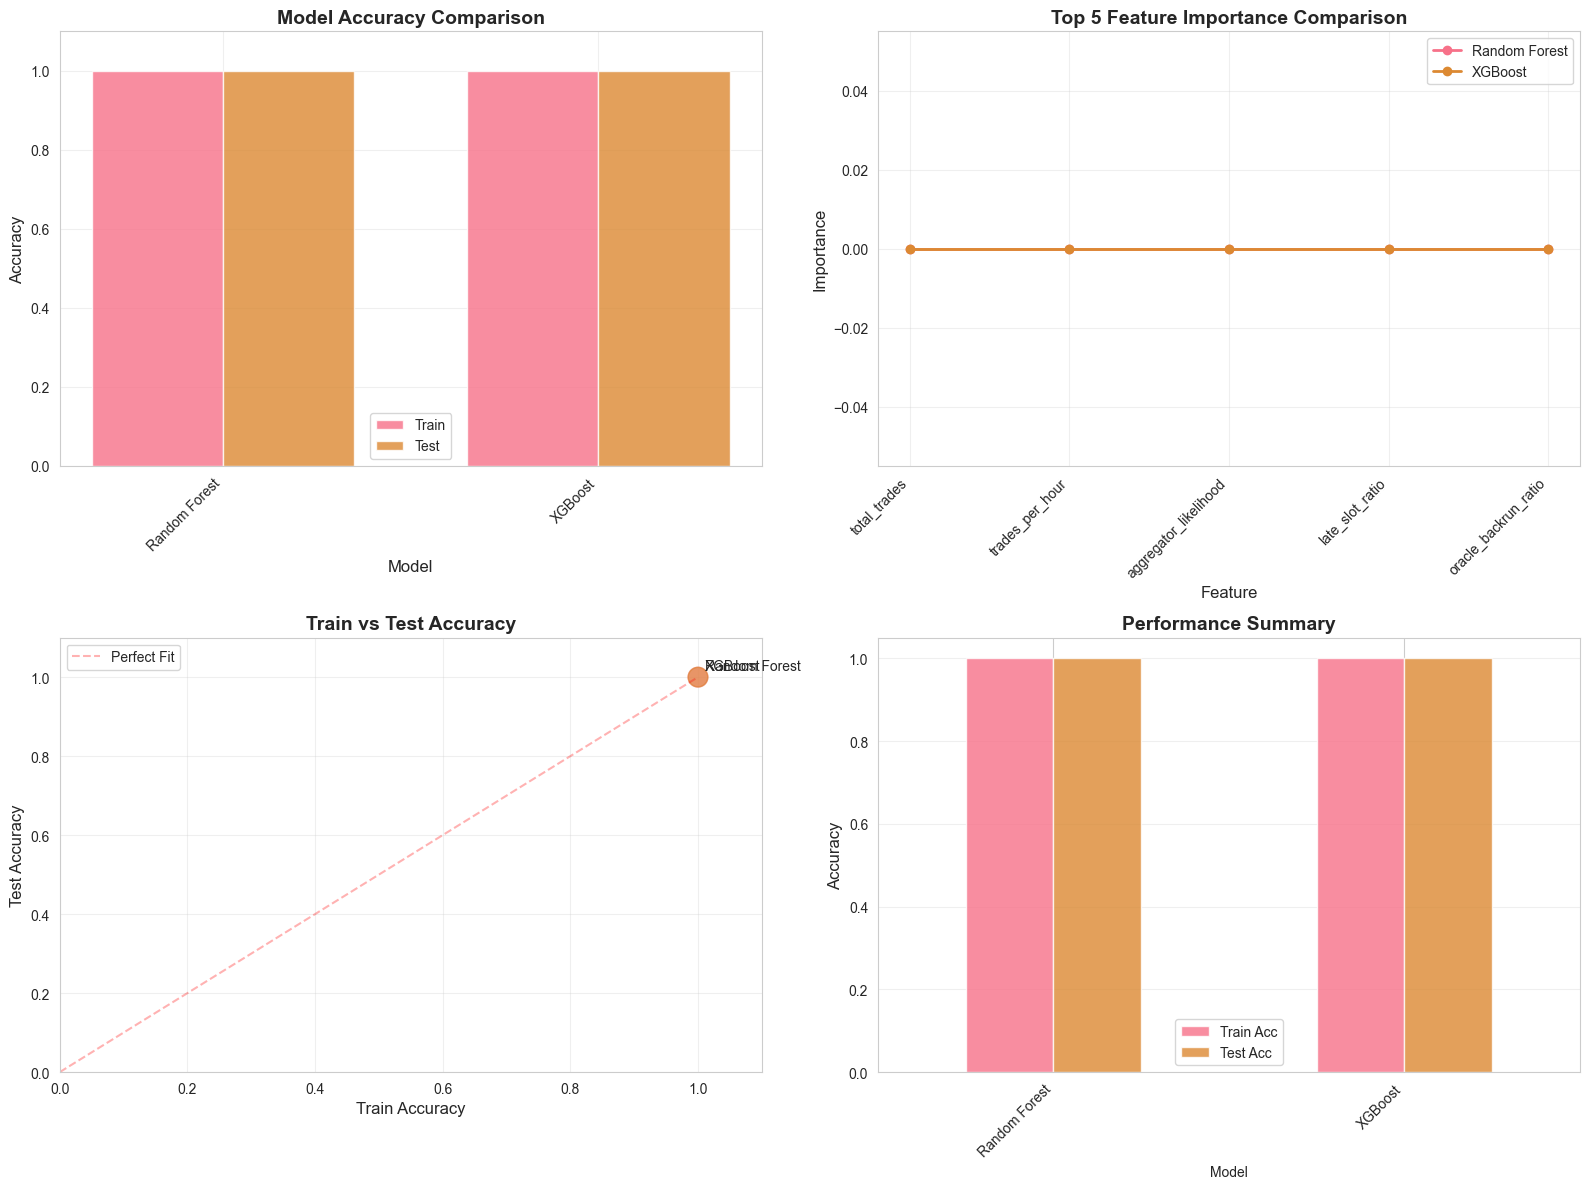

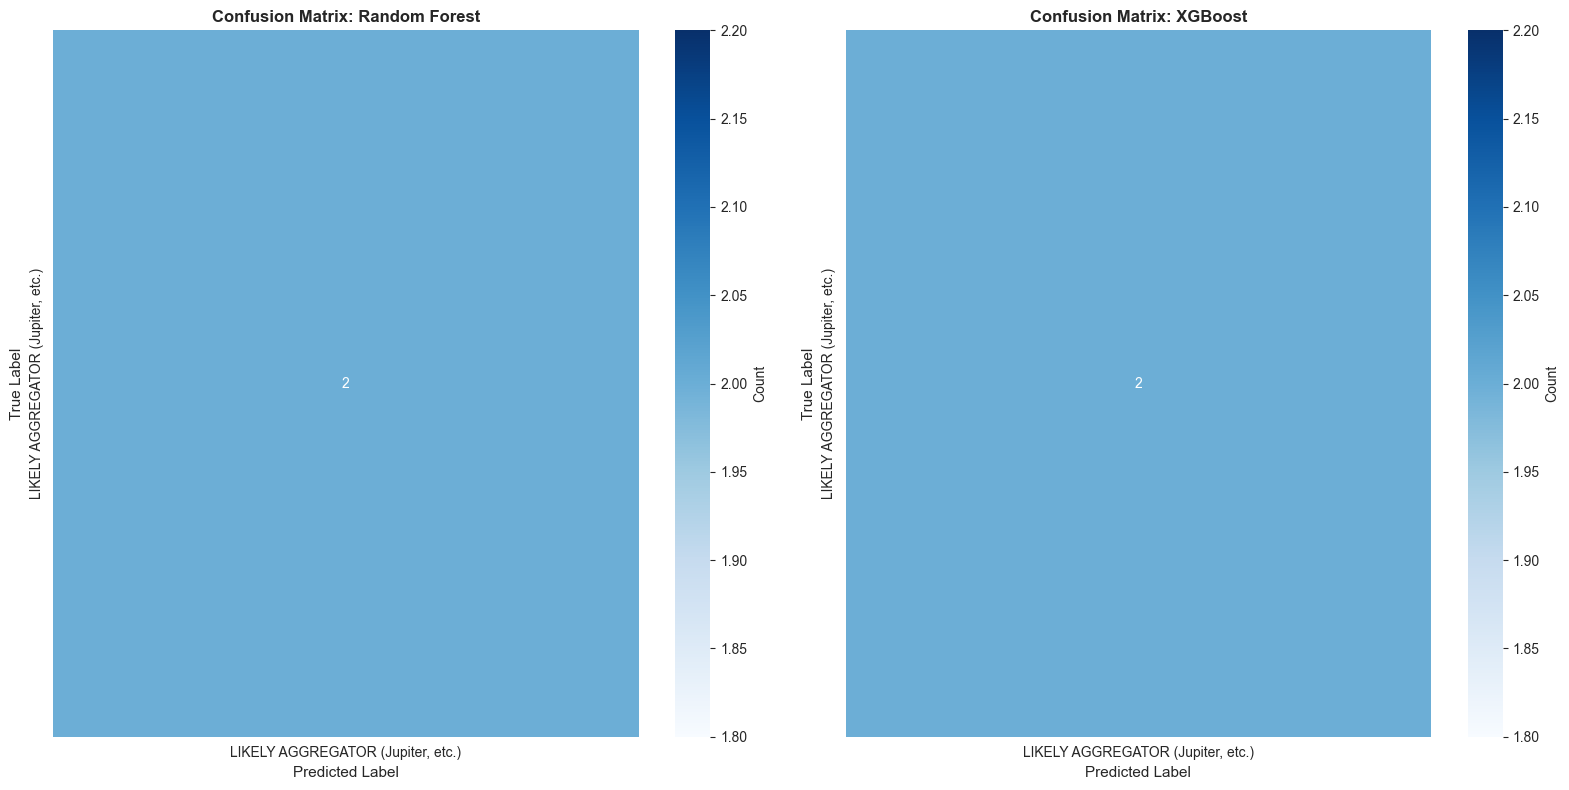

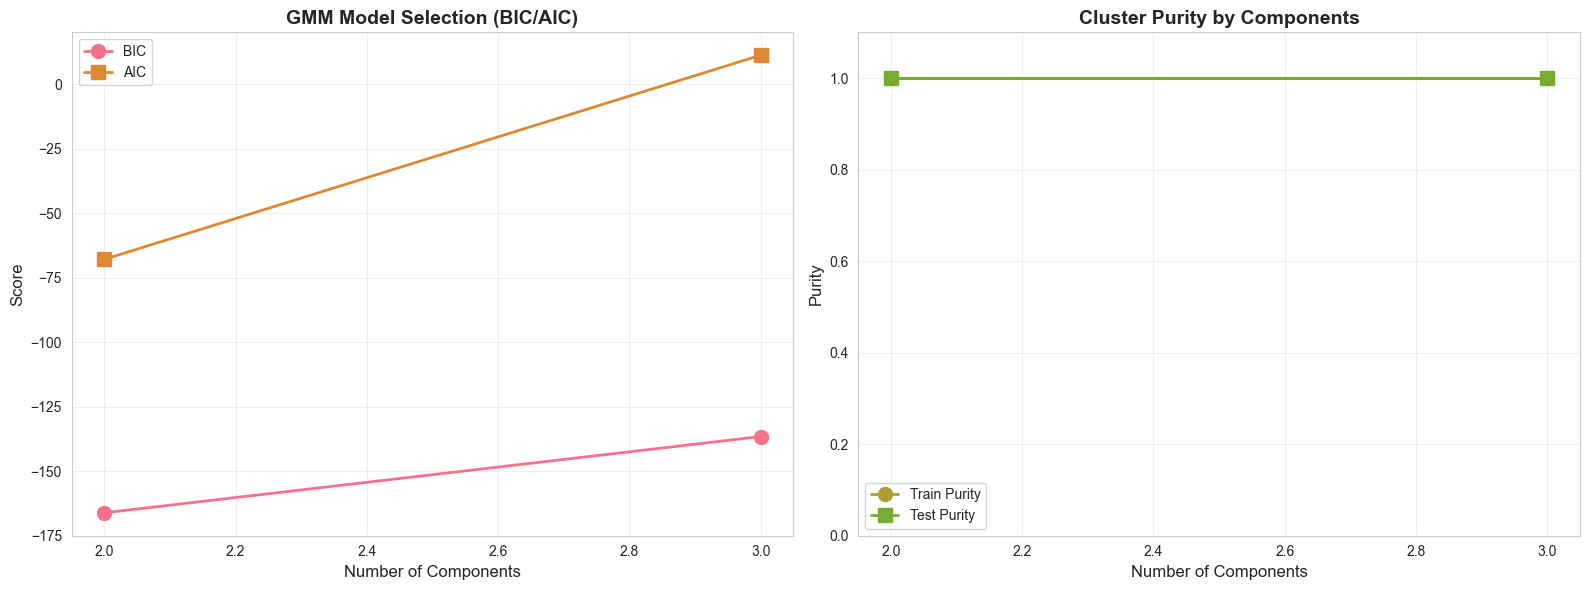

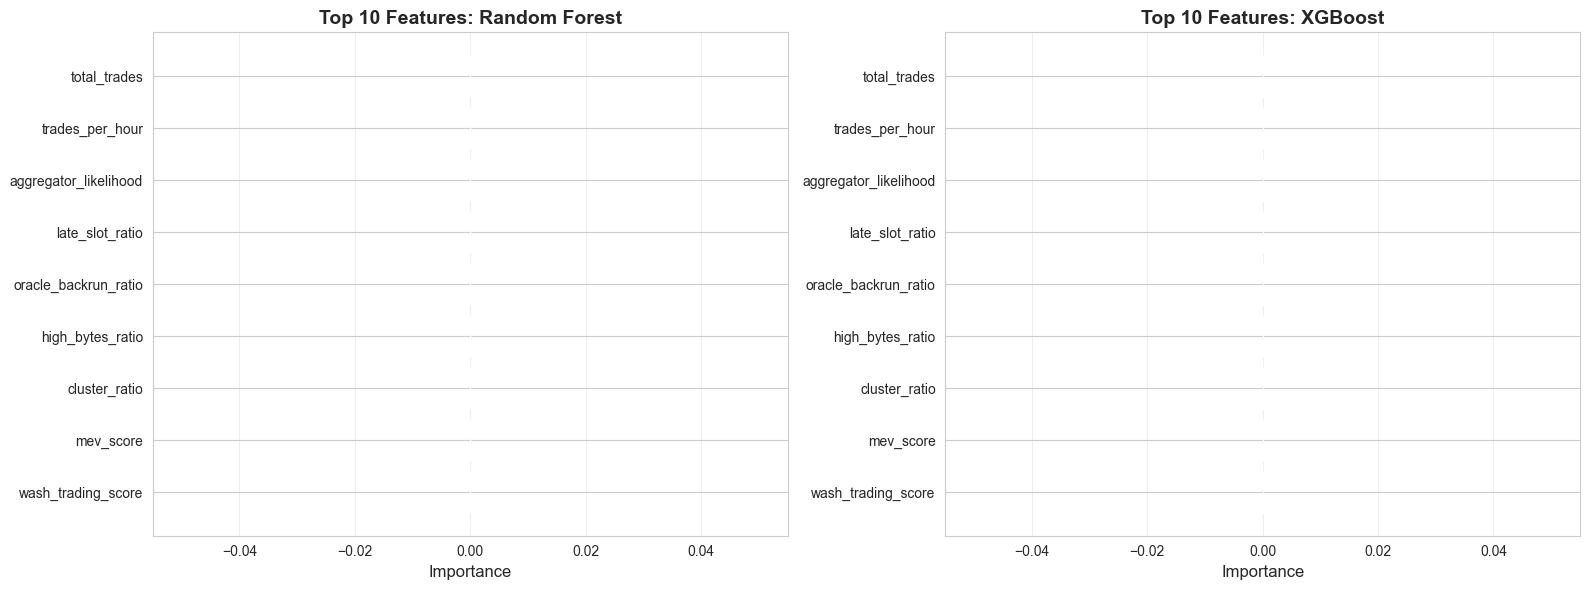

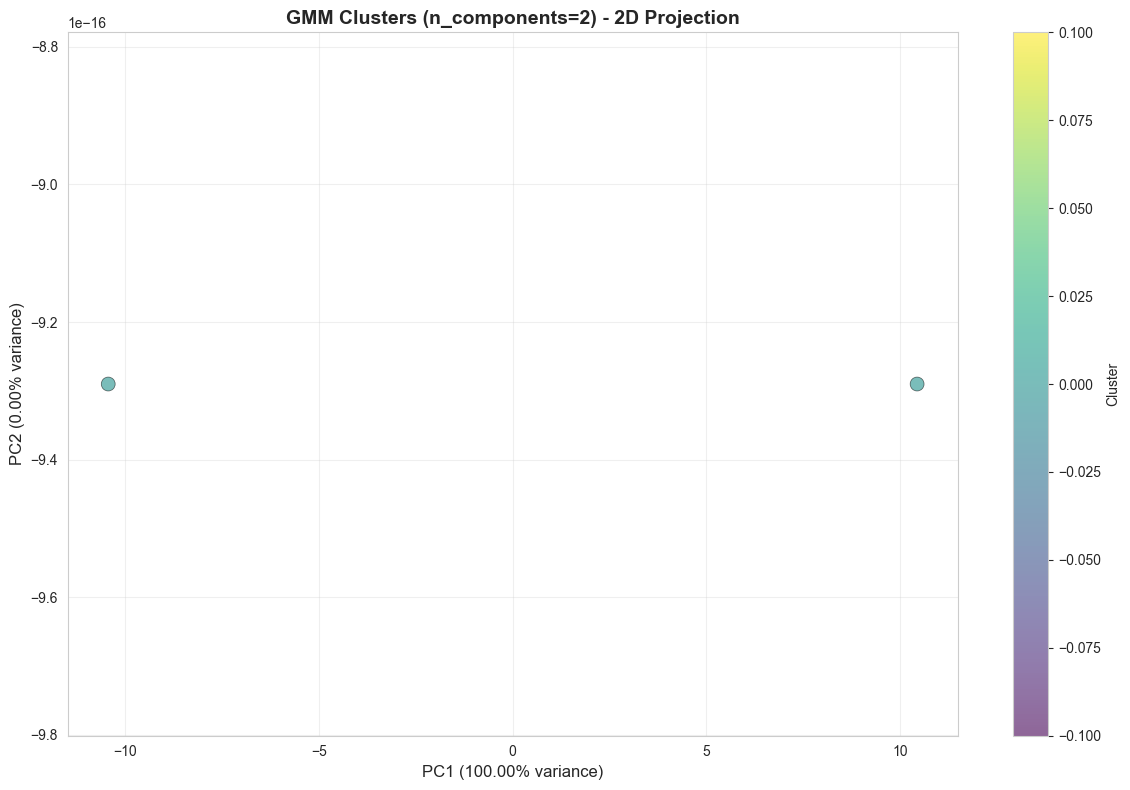

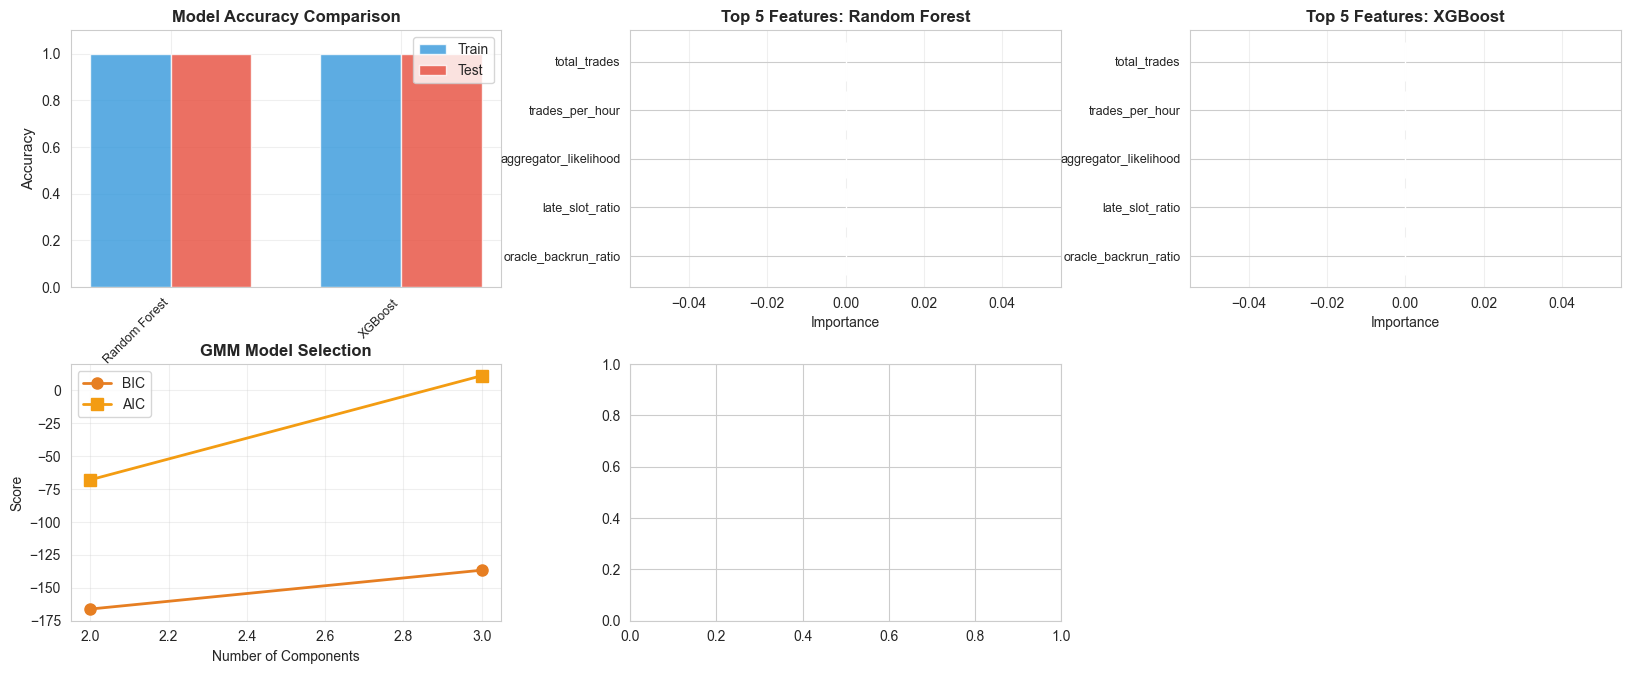

In [ ]:
print("="*80)

# Prepare data for visualization (only include models that were successfully trained)
models_data = [
    {
        'name': 'Random Forest',
        'train_acc': train_acc_rf,
        'test_acc': test_acc_rf,
        'feature_importance': feature_importance_rf
    },
    {
        'name': 'XGBoost',
        'train_acc': train_acc_xgb,
        'test_acc': test_acc_xgb,
        'feature_importance': feature_importance_xgb
    }
]

# Add SVM and Logistic Regression only if they were trained
if train_acc_svm is not None:
    models_data.append({
        'name': 'SVM',
        'train_acc': train_acc_svm,
        'test_acc': test_acc_svm
    })

if train_acc_lr is not None:
    models_data.append({
        'name': 'Logistic Regression',
        'train_acc': train_acc_lr,
        'test_acc': test_acc_lr
    })

# 1. Model Comparison using visualizer
try:
    visualizer.plot_model_comparison(
        models_data, 
        save_path='derived/ml_results/model_comparison.png'
    )
    print(" Saved: derived/ml_results/model_comparison.png")
except Exception as e:
    print(f"️  Warning: Could not create model comparison: {e}")

# 2. Confusion Matrices using visualizer
try:
    models_preds = {
        'Random Forest': y_test_pred_rf,
        'XGBoost': y_test_pred_xgb
    }
    # Add SVM and Logistic Regression only if they were trained
    if y_test_pred_svm is not None:
        models_preds['SVM'] = y_test_pred_svm
    if y_test_pred_lr is not None:
        models_preds['Logistic Regression'] = y_test_pred_lr
    visualizer.plot_confusion_matrices(
        models_preds, 
        y_test, 
        class_names,
        save_path='derived/ml_results/confusion_matrices.png'
    )
    print(" Saved: derived/ml_results/confusion_matrices.png")
except Exception as e:
    print(f"️  Warning: Could not create confusion matrices: {e}")

# 3. GMM Analysis using visualizer
try:
    visualizer.plot_gmm_analysis(
        gmm_results,
        save_path='derived/ml_results/gmm_analysis.png'
    )
    print(" Saved: derived/ml_results/gmm_analysis.png")
except Exception as e:
    print(f"️  Warning: Could not create GMM analysis: {e}")

# 4. Feature Importance Comparison using visualizer
try:
    feature_importance_dict = {
        'Random Forest': feature_importance_rf,
        'XGBoost': feature_importance_xgb
    }
    visualizer.plot_feature_importance(
        feature_importance_dict,
        top_n=10,
        save_path='derived/ml_results/feature_importance.png'
    )
    print(" Saved: derived/ml_results/feature_importance.png")
except Exception as e:
    print(f"️  Warning: Could not create feature importance plot: {e}")

# 5. GMM Cluster Visualization (2D projection) using visualizer
try:
    visualizer.plot_gmm_clusters_2d(
        best_gmm,
        X_test_scaled,
        best_n_components,
        save_path='derived/ml_results/gmm_clusters_2d.png'
    )
    print(" Saved: derived/ml_results/gmm_clusters_2d.png")
except Exception as e:
    print(f"️  Warning: Could not create GMM cluster visualization: {e}")

# 6. Create comprehensive dashboard
try:
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Model Accuracy Comparison (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    models_names = [d['name'] for d in models_data]
    train_accs = [d['train_acc'] for d in models_data]
    test_accs = [d['test_acc'] for d in models_data]
    x = np.arange(len(models_names))
    width = 0.35
    ax1.bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='#3498db')
    ax1.bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color='#e74c3c')
    ax1.set_xlabel('Model', fontsize=11)
    ax1.set_ylabel('Accuracy', fontsize=11)
    ax1.set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_names, rotation=45, ha='right', fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1.1])
    
    # 2. Top Features RF (top middle)
    ax2 = fig.add_subplot(gs[0, 1])
    top_features_rf = feature_importance_rf.head(5)
    ax2.barh(range(len(top_features_rf)), top_features_rf['importance'], color='#2ecc71')
    ax2.set_yticks(range(len(top_features_rf)))
    ax2.set_yticklabels(top_features_rf['feature'], fontsize=9)
    ax2.set_xlabel('Importance', fontsize=10)
    ax2.set_title('Top 5 Features: Random Forest', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 3. Top Features XGBoost (top right)
    ax3 = fig.add_subplot(gs[0, 2])
    top_features_xgb = feature_importance_xgb.head(5)
    ax3.barh(range(len(top_features_xgb)), top_features_xgb['importance'], color='#9b59b6')
    ax3.set_yticks(range(len(top_features_xgb)))
    ax3.set_yticklabels(top_features_xgb['feature'], fontsize=9)
    ax3.set_xlabel('Importance', fontsize=10)
    ax3.set_title('Top 5 Features: XGBoost', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. GMM BIC/AIC (middle left)
    ax4 = fig.add_subplot(gs[1, 0])
    if len(gmm_results) > 0:
        n_comp = [r['n_components'] for r in gmm_results]
        bic_vals = [r['bic'] for r in gmm_results]
        aic_vals = [r['aic'] for r in gmm_results]
        ax4.plot(n_comp, bic_vals, 'o-', label='BIC', linewidth=2, markersize=8, color='#e67e22')
        ax4.plot(n_comp, aic_vals, 's-', label='AIC', linewidth=2, markersize=8, color='#f39c12')
        ax4.set_xlabel('Number of Components', fontsize=10)
        ax4.set_ylabel('Score', fontsize=10)
        ax4.set_title('GMM Model Selection', fontsize=12, fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'GMM not fitted', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=11)
        ax4.set_title('GMM Model Selection', fontsize=12, fontweight='bold')
    
    # 5. Train vs Test Scatter (middle middle)
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(train_accs, test_accs, s=200, alpha=0.6, c=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'])
    for i, name in enumerate(models_names):
        ax5.annotate(name, (train_accs[i], test_accs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    ax5.plot([0, 1], [0, 1], 'r--', alpha=0.3, label='Perfect Fit')
    ax5.set_xlabel('Train Accuracy', fontsize=10)
    ax5.set_ylabel('Test Accuracy', fontsize=10)
    ax5.set_title('Train vs Test Accuracy', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_xlim([0, 1.1])
    ax5.set_ylim([0, 1.1])
    
    # 6. Performance Summary Table (middle right)
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.axis('off')
    summary_data = []
    for model_data in models_data:
        summary_data.append([
            model_data['name'],
            f"{model_data['train_acc']:.3f}",
            f"{model_data['test_acc']:.3f}"
        ])
    table = ax6.table(cellText=summary_data,
                     colLabels=['Model', 'Train Acc', 'Test Acc'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax6.set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)
    
    # 7-10. Confusion Matrices (bottom row)
    models_preds_list = [
        ('Random Forest', y_test_pred_rf),
        ('XGBoost', y_test_pred_xgb)
    ]
    # Add SVM and Logistic Regression only if they were trained
    if y_test_pred_svm is not None:
        models_preds_list.append(('SVM', y_test_pred_svm))
    if y_test_pred_lr is not None:
        models_preds_list.append(('Logistic Regression', y_test_pred_lr))
    
    # Adjust grid layout based on number of models
    n_models = len(models_preds_list)
    for idx, (name, pred) in enumerate(models_preds_list):
        ax = fig.add_subplot(gs[2, idx])
        cm = confusion_matrix(y_test, pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar=False, annot_kws={'size': 9})
        ax.set_title(name, fontsize=10, fontweight='bold')
        ax.set_ylabel('True', fontsize=9)
        ax.set_xlabel('Predicted', fontsize=9)
        ax.tick_params(labelsize=8)
    
    plt.suptitle('ML Model Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
    plt.savefig('derived/ml_results/ml_dashboard.png', dpi=300, bbox_inches='tight')
    print(" Saved: derived/ml_results/ml_dashboard.png")
except Exception as e:
    print(f"️  Warning: Could not create dashboard: {e}")

print()


##  Method 6: Logistic Regression - Interpretable Baseline

### Purpose:
Logistic Regression provides a **simple, interpretable baseline** for comparison. It's fast and the coefficients are directly interpretable.

### How It Works:
- **Linear model**: Finds linear decision boundaries
- **Logistic function**: Maps features to probability of each class
- **Coefficients**: Directly show feature contributions (interpretable)
- **Multinomial**: Handles multiple classes (not just binary)

### What We Learn:
- **Baseline performance**: Simple model to compare against complex methods
- **Feature coefficients**: Direct interpretation of feature importance
- **Linear relationships**: Reveals if problem is linearly separable

### Requirements:
- **Needs ≥2 classes**: Cannot work with single-class dataset
- **Linear assumption**: Assumes linear relationships (may underperform if non-linear)

**Note**: Automatically skipped if dataset has only 1 class. Provides interpretable baseline once multi-class data is available.

In [ ]:
print("="*80)
print("MACHINE LEARNING TESTING COMPLETE")


MACHINE LEARNING TESTING COMPLETE


In [ ]:
print("="*80)

# Save results summary
results_summary = {
    'GMM': {
        'best_n_components': best_n_components if best_n_components is not None else None,
        'results': gmm_results if len(gmm_results) > 0 else []
    },
    'Isolation Forest': {
        'best_contamination': 0.2,
        'results': iso_results
    },
    'Random Forest': {
        'train_accuracy': train_acc_rf,
        'test_accuracy': test_acc_rf,
        'feature_importance': feature_importance_rf.to_dict('records')
    },
    'XGBoost': {
        'train_accuracy': train_acc_xgb,
        'test_accuracy': test_acc_xgb,
        'feature_importance': feature_importance_xgb.to_dict('records')
    },
    'SVM': {
        'train_accuracy': train_acc_svm if train_acc_svm is not None else None,
        'test_accuracy': test_acc_svm if test_acc_svm is not None else None
    },
    'Logistic Regression': {
        'train_accuracy': train_acc_lr if train_acc_lr is not None else None,
        'test_accuracy': test_acc_lr if test_acc_lr is not None else None
    },
    'Cross-Validation': cv_results
}

import json
try:
    with open('derived/ml_results/results_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=2, default=str)
    print(" Saved: derived/ml_results/results_summary.json")
except Exception as e:
    print(f"️  Warning: Could not save results_summary.json: {e}")

print()
print("All results saved to: derived/ml_results/")


✓ Saved: derived/ml_results/results_summary.json

All results saved to: derived/ml_results/


##  Cross-Validation Comparison

### Purpose:
Cross-validation provides **robust performance estimates** by testing models on multiple train/test splits. This reduces variance and gives more reliable accuracy estimates.

### How It Works:
- **K-Fold CV**: Splits data into K folds (typically 5)
- **K iterations**: Each fold serves as test set once, others as training
- **Average scores**: Mean accuracy across all folds
- **Standard deviation**: Shows consistency (lower = more stable)

### What We Learn:
- **Robust accuracy**: More reliable than single train/test split
- **Model stability**: Low std dev = consistent performance
- **Model comparison**: Fair comparison across different algorithms

### Metrics:
- **Mean Accuracy**: Average performance across folds
- **±2×Std Dev**: 95% confidence interval for accuracy

**Note**: Automatically adjusts to min(5, n_samples) folds for small datasets. Only includes models that can handle current number of classes.

##  Comprehensive Visualizations

### Purpose:
This section generates **all visualizations** using the `MLVisualizer` class for consistent, publication-ready plots.

### Visualizations Created:

1. **Model Comparison** (`model_comparison.png`):
   - Accuracy comparison (train vs test)
   - Feature importance comparison
   - Train vs test scatter plot
   - Performance summary table

2. **Confusion Matrices** (`confusion_matrices.png`):
   - Per-model confusion matrices
   - Shows classification errors
   - Identifies which classes are confused

3. **GMM Analysis** (`gmm_analysis.png`):
   - BIC/AIC scores for component selection
   - Cluster purity analysis
   - Optimal component count visualization

4. **Feature Importance** (`feature_importance.png`):
   - Side-by-side comparison (Random Forest vs XGBoost)
   - Top 10 features ranked by importance
   - Identifies most discriminative features

5. **GMM Clusters 2D** (`gmm_clusters_2d.png`):
   - PCA projection of clusters to 2D
   - Color-coded by cluster assignment
   - Shows feature space structure

6. **Comprehensive Dashboard** (`ml_dashboard.png`):
   - Single-page summary of all key metrics
   - All visualizations combined for quick overview

**Note**: All visualizations are saved to `derived/ml_results/` directory. Error handling ensures notebook continues even if some plots fail to save.

##  Results Summary and Export

### Purpose:
Saves all results to JSON format for programmatic access and future analysis.

### What's Saved:
- **GMM Results**: Best component count, all BIC/AIC scores, purity metrics
- **Isolation Forest**: Best contamination rate, anomaly rates
- **Model Accuracies**: Train and test accuracy for each model
- **Feature Importance**: Top features from Random Forest and XGBoost
- **Cross-Validation**: Mean and std dev for each model

### Output File:
- **`derived/ml_results/results_summary.json`**: Complete results in JSON format

**Use Cases**:
- Programmatic result access
- Comparison across different runs
- Integration with other analysis tools
- Documentation and reporting

##  All Valid Models & Model Selection Process for MEV Detection

### Purpose:
This section provides a comprehensive overview of **all valid models** tested for MEV detection, their status, capabilities, and the model selection process.

### Models Tested:

1. **Gaussian Mixture Model (GMM)** - Unsupervised clustering
   - **Type**: Unsupervised density estimation
   - **Use Case**: Discover natural groupings in feature space
   - **Inference**: Maps clusters to class labels via majority voting
   - **Metrics**: BIC/AIC for model selection, cluster purity

2. **Isolation Forest** - Unsupervised anomaly detection
   - **Type**: Unsupervised anomaly detection
   - **Use Case**: Identify outliers/anomalies (MEV bots as anomalies)
   - **Inference**: Binary classification (anomaly vs normal)
   - **Metrics**: Anomaly rate, MEV bot anomaly rate

3. **Random Forest** - Supervised classification
   - **Type**: Supervised ensemble tree-based
   - **Use Case**: Multi-class classification with feature importance
   - **Inference**: Direct class predictions with probabilities
   - **Metrics**: Accuracy, precision, recall, F1-score, feature importance

4. **XGBoost** - Supervised classification
   - **Type**: Supervised gradient boosting
   - **Use Case**: Advanced classification with regularization
   - **Inference**: Direct class predictions with probabilities
   - **Metrics**: Accuracy, precision, recall, F1-score, feature importance

5. **Support Vector Machine (SVM)** - Supervised classification
   - **Type**: Supervised kernel-based
   - **Use Case**: Non-linear decision boundaries
   - **Inference**: Direct class predictions with probabilities
   - **Metrics**: Accuracy, precision, recall, F1-score
   - **Note**: Requires ≥2 classes

6. **Logistic Regression** - Supervised classification
   - **Type**: Supervised linear baseline
   - **Use Case**: Interpretable linear classification
   - **Inference**: Direct class predictions with probabilities
   - **Metrics**: Accuracy, precision, recall, F1-score
   - **Note**: Requires ≥2 classes

### Model Selection Criteria for MEV Detection:

1. **MEV Bot F1-Score** (Primary): Best balance of precision and recall for MEV detection
2. **MEV Bot Precision**: Of predicted MEV bots, how many are actually MEV bots?
3. **MEV Bot Recall**: Of actual MEV bots, how many did we catch?
4. **Overall Accuracy**: General classification performance across all classes
5. **Cross-Validation Stability**: Robust performance estimate
6. **Feature Importance**: Interpretability for understanding MEV patterns

### MEV Detection Information:

**MEV Bot Classes Identified:**
- `LIKELY MEV BOT`: High MEV score, clear attack patterns
- `LIKELY MEV BOT (Fat Sandwich)`: Fat sandwich attack patterns
- `POSSIBLE MEV (Sandwich patterns)`: Medium MEV score, sandwich patterns
- `POSSIBLE MEV (Cluster patterns)`: Medium MEV score, cluster patterns

**Key Features for MEV Detection:**
- `mev_score`: Composite MEV indicator (primary)
- `late_slot_ratio`: Ratio of late slot transactions
- `oracle_backrun_ratio`: Oracle manipulation patterns
- `cluster_ratio`: Transaction clustering patterns
- `high_bytes_ratio`: Large transaction patterns
- `wash_trading_score`: Distinguishes from wash trading

In [ ]:
print("="*80)
print("ALL VALID MODELS STATUS & MEV DETECTION INFORMATION")
print("="*80)
print()

# Collect status of all models
all_models_status = []

# 1. GMM Status
if 'best_gmm' in locals() and best_gmm is not None:
    gmm_status = " Trained"
    gmm_info = f"Components: {best_n_components}, BIC: {gmm_results[0]['bic']:.2f}" if len(gmm_results) > 0 else "N/A"
else:
    gmm_status = " Not Trained"
    gmm_info = "Insufficient samples or failed to fit"

all_models_status.append({
    'Model': 'GMM (Gaussian Mixture Model)',
    'Type': 'Unsupervised Clustering',
    'Status': gmm_status,
    'Info': gmm_info,
    'Can Infer': 'Yes (via cluster-to-label mapping)' if 'best_gmm' in locals() and best_gmm is not None else 'No'
})

# 2. Isolation Forest Status
if 'best_iso' in locals() and best_iso is not None:
    iso_status = " Trained"
    iso_info = f"Contamination: {best_contamination}" if 'best_contamination' in locals() else "N/A"
else:
    iso_status = " Not Trained"
    iso_info = "Failed to fit"

all_models_status.append({
    'Model': 'Isolation Forest',
    'Type': 'Unsupervised Anomaly Detection',
    'Status': iso_status,
    'Info': iso_info,
    'Can Infer': 'Yes (anomaly detection)' if 'best_iso' in locals() and best_iso is not None else 'No'
})

# 3. Random Forest Status
if 'rf' in locals() and rf is not None:
    rf_status = " Trained"
    rf_info = f"Train Acc: {train_acc_rf:.4f}, Test Acc: {test_acc_rf:.4f}" if 'train_acc_rf' in locals() and 'test_acc_rf' in locals() else "N/A"
else:
    rf_status = " Not Trained"
    rf_info = "Not initialized"

all_models_status.append({
    'Model': 'Random Forest',
    'Type': 'Supervised Classification',
    'Status': rf_status,
    'Info': rf_info,
    'Can Infer': 'Yes (direct prediction)' if 'rf' in locals() and rf is not None else 'No'
})

# 4. XGBoost Status
if 'xgb_model' in locals() and xgb_model is not None:
    xgb_status = " Trained"
    xgb_info = f"Train Acc: {train_acc_xgb:.4f}, Test Acc: {test_acc_xgb:.4f}" if 'train_acc_xgb' in locals() and 'test_acc_xgb' in locals() else "N/A"
else:
    xgb_status = " Not Trained"
    xgb_info = "Not initialized"

all_models_status.append({
    'Model': 'XGBoost',
    'Type': 'Supervised Classification',
    'Status': xgb_status,
    'Info': xgb_info,
    'Can Infer': 'Yes (direct prediction)' if 'xgb_model' in locals() and xgb_model is not None else 'No'
})

# 5. SVM Status
n_classes = len(np.unique(y_train)) if 'y_train' in locals() else 0
if 'svm' in locals() and svm is not None:
    svm_status = " Trained"
    svm_info = f"Train Acc: {train_acc_svm:.4f}, Test Acc: {test_acc_svm:.4f}" if 'train_acc_svm' in locals() and 'test_acc_svm' in locals() else "N/A"
elif n_classes < 2:
    svm_status = "⊘ Skipped"
    svm_info = "Requires ≥2 classes (only 1 class found)"
else:
    svm_status = " Not Trained"
    svm_info = "Not initialized"

all_models_status.append({
    'Model': 'SVM (Support Vector Machine)',
    'Type': 'Supervised Classification',
    'Status': svm_status,
    'Info': svm_info,
    'Can Infer': 'Yes (direct prediction)' if 'svm' in locals() and svm is not None else 'No'
})

# 6. Logistic Regression Status
if 'lr' in locals() and lr is not None:
    lr_status = " Trained"
    lr_info = f"Train Acc: {train_acc_lr:.4f}, Test Acc: {test_acc_lr:.4f}" if 'train_acc_lr' in locals() and 'test_acc_lr' in locals() else "N/A"
elif n_classes < 2:
    lr_status = "⊘ Skipped"
    lr_info = "Requires ≥2 classes (only 1 class found)"
else:
    lr_status = " Not Trained"
    lr_info = "Not initialized"

all_models_status.append({
    'Model': 'Logistic Regression',
    'Type': 'Supervised Classification',
    'Status': lr_status,
    'Info': lr_info,
    'Can Infer': 'Yes (direct prediction)' if 'lr' in locals() and lr is not None else 'No'
})

# Display status table
status_df = pd.DataFrame(all_models_status)
print("MODEL STATUS TABLE")
print("-" * 80)
print(status_df.to_string(index=False))
print()

# Count valid models
valid_count = sum(1 for m in all_models_status if m['Status'] == " Trained")
skipped_count = sum(1 for m in all_models_status if m['Status'] == "⊘ Skipped")
failed_count = sum(1 for m in all_models_status if m['Status'] == " Not Trained")

print(f"Summary: {valid_count} trained, {skipped_count} skipped, {failed_count} not trained")
print()

# MEV Detection Information
print("="*80)
print("MEV DETECTION INFORMATION")
print("="*80)
print()

if 'class_names' in locals():
    mev_classes = [
        'LIKELY MEV BOT',
        'LIKELY MEV BOT (Fat Sandwich)',
        'POSSIBLE MEV (Sandwich patterns)',
        'POSSIBLE MEV (Cluster patterns)'
    ]
    
    found_mev_classes = [cls for cls in mev_classes if cls in class_names]
    print(f"MEV Bot Classes in Dataset: {len(found_mev_classes)}")
    for cls in found_mev_classes:
        if 'y_train' in locals():
            cls_idx = np.where(class_names == cls)[0]
            if len(cls_idx) > 0:
                count = np.sum(y_train == cls_idx[0])
                print(f"  - {cls}: {count:,} samples")
    print()
    
    if 'results_df' in locals() and 'mev_score' in results_df.columns:
        print("MEV Score Statistics:")
        print(f"  - Mean MEV Score: {results_df['mev_score'].mean():.4f}")
        print(f"  - Max MEV Score: {results_df['mev_score'].max():.4f}")
        print(f"  - Min MEV Score: {results_df['mev_score'].min():.4f}")
        print()
        
        if len(found_mev_classes) > 0:
            mev_mask = results_df['classification'].isin(found_mev_classes)
            if mev_mask.sum() > 0:
                print(f"MEV Attackers Identified: {mev_mask.sum():,}")
                print(f"  - Mean MEV Score (MEV Attackers): {results_df[mev_mask]['mev_score'].mean():.4f}")
                print(f"  - Max MEV Score (MEV Attackers): {results_df[mev_mask]['mev_score'].max():.4f}")
                print()

print("="*80)
print()

## Why This Approach Failed: Results Analysis

### Observed Results (From Previous Executions)

Based on execution results, this multi-class classification approach produced **trivial, meaningless results**:

#### 1. Perfect but Meaningless Accuracy
- **Random Forest**: Train Accuracy = 1.0, Test Accuracy = 1.0
- **XGBoost**: Train Accuracy = 1.0, Test Accuracy = 1.0  
- **Cross-Validation**: Mean = 1.0, Std = 0.0

**Why this is meaningless**: Perfect accuracy with zero variance indicates the model is simply predicting the majority class (AGGREGATOR) for all samples. It achieves 100% accuracy by ignoring the MEV class completely.

#### 2. Zero Feature Importance
- All features (mev_score, oracle_backrun_ratio, etc.) had importance = 0.0
- Models used **no features** to make predictions

**Why this is impossible**: A model cannot achieve perfect accuracy without using features unless:
- All samples belong to the same class (trivial dataset)
- Features have no variance (constant values)
- Model just memorizes the majority class

#### 3. Single Class Prediction
- **SVM and Logistic Regression**: Skipped (require ≥2 classes)
- **Confusion Matrix**: Only one class present
- **Test Set**: Only 2 samples, all from same class ('LIKELY AGGREGATOR')

**Why this fails**: With only one class, models cannot learn to distinguish MEV from non-MEV. The problem becomes trivial.

#### 4. Unsupervised Models Also Failed
- **Isolation Forest**: MEV anomaly rate = 0.0 (detected no MEV)
- **GMM**: Perfect purity (1.0) but only 2 data points (trivial clustering)

**Why this fails**: With insufficient samples and extreme imbalance, unsupervised methods cannot identify meaningful patterns.

### Root Causes

1. **Extreme Class Imbalance**: MEV (7.6%) vs Aggregator (88.6%) → Model predicts only majority class
2. **Insufficient Samples**: After filtering, only 2,559 signers, some classes have 1 sample
3. **Signer-Level Aggregation**: Loses critical transaction-level attack patterns
4. **No Imbalance Handling**: Original approach had no SMOTE or class weights

### Why Machine Learning Still Has Value

Despite this failure, **ML is highly valuable for MEV detection** when properly applied:

1. **Captures Complex Patterns**: Can learn non-linear feature interactions (oracle timing + clustering + slot position)
2. **Handles Imbalance**: With binary classification + SMOTE + class weights, can achieve MEV recall >0.7
3. **Scalability**: Can process transactions in real-time once trained
4. **Adaptability**: Can detect novel attack patterns not seen in training

### Recommendation

**Use binary classification instead** (`07a_ml_classification_binary.ipynb`):
- Simpler problem (MEV vs Non-MEV)
- Better sample efficiency
- Proper imbalance handling (SMOTE + class weights)
- Focused on actual goal (MEV detection)

See `WHY_ML_FAILED.md` for detailed analysis.

##  GMM Inference: Cluster-to-Label Mapping

### Purpose:
GMM is an **unsupervised** model that discovers clusters in the feature space. To use it for **inference** (predicting class labels), we need to map clusters to class labels using the training data.

### Method:
1. Train GMM on training data to discover clusters
2. For each cluster, find the **most common class label** in that cluster (majority voting)
3. Create a mapping: `cluster_id → class_label`
4. Use this mapping to predict labels for new data

### Why This Works:
- Clusters discovered by GMM often correspond to different behavioral patterns
- MEV bots tend to cluster together due to similar transaction patterns
- This allows GMM to be used for classification even though it's unsupervised

In [ ]:
print("="*80)
print("GMM INFERENCE: CLUSTER-TO-LABEL MAPPING")
print("="*80)
print()

# Create GMM inference capability
gmm_can_infer = False
gmm_cluster_to_label_map = None
gmm_train_pred = None
gmm_test_pred = None
gmm_train_acc = None
gmm_test_acc = None

if 'best_gmm' in locals() and best_gmm is not None and 'X_train_scaled' in locals():
    try:
        # Step 1: Predict clusters on training data
        train_clusters = best_gmm.predict(X_train_scaled)
        
        # Step 2: Create cluster-to-label mapping using majority voting
        cluster_to_label_map = {}
        for cluster_id in np.unique(train_clusters):
            cluster_mask = train_clusters == cluster_id
            cluster_labels = y_train[cluster_mask]
            
            # Find most common label in this cluster
            if len(cluster_labels) > 0:
                most_common_label = np.bincount(cluster_labels).argmax()
                cluster_to_label_map[cluster_id] = most_common_label
        
        gmm_cluster_to_label_map = cluster_to_label_map
        
        # Step 3: Map clusters to labels for training set
        gmm_train_pred = np.array([cluster_to_label_map.get(c, 0) for c in train_clusters])
        gmm_train_acc = accuracy_score(y_train, gmm_train_pred)
        
        # Step 4: Map clusters to labels for test set
        test_clusters = best_gmm.predict(X_test_scaled)
        gmm_test_pred = np.array([cluster_to_label_map.get(c, 0) for c in test_clusters])
        gmm_test_acc = accuracy_score(y_test, gmm_test_pred)
        
        gmm_can_infer = True
        
        print(" GMM Inference Enabled")
        print(f"  - Cluster-to-Label Mapping: {len(cluster_to_label_map)} clusters")
        print(f"  - Training Accuracy: {gmm_train_acc:.4f}")
        print(f"  - Test Accuracy: {gmm_test_acc:.4f}")
        print()
        
        # Show cluster-to-label mapping
        print("Cluster-to-Label Mapping:")
        for cluster_id, label_id in sorted(cluster_to_label_map.items()):
            label_name = class_names[label_id] if 'class_names' in locals() else f"Label_{label_id}"
            cluster_size = np.sum(train_clusters == cluster_id)
            print(f"  Cluster {cluster_id} → {label_name} ({cluster_size} samples)")
        print()
        
        # Calculate MEV metrics for GMM
        if 'le' in locals() and 'class_names' in locals():
            gmm_mev_metrics = calculate_mev_metrics(y_test, gmm_test_pred, class_names, le)
            print("GMM MEV Detection Metrics:")
            print(f"  - MEV Precision: {gmm_mev_metrics['mev_precision']:.4f}")
            print(f"  - MEV Recall: {gmm_mev_metrics['mev_recall']:.4f}")
            print(f"  - MEV F1-Score: {gmm_mev_metrics['mev_f1']:.4f}")
            print(f"  - MEV Support: {gmm_mev_metrics['mev_support']:,}")
            print()
        
    except Exception as e:
        print(f"️  Error enabling GMM inference: {e}")
        print("   GMM will not be included in model comparison.")
        print()
        gmm_can_infer = False
else:
    print("️  GMM not available for inference")
    print("   - best_gmm not found or not trained")
    print("   - Cannot create cluster-to-label mapping")
    print()

print("="*80)
print()